In [1]:
# import modules needed for EDA

import pandas as pd
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import yeojohnson
from scipy.stats import normaltest
import statsmodels.formula.api as smf

# import the class created previously to convert the data types in the table
from class_converter import DataTransform

In [2]:
# load in the loan payments dataset as a pandas data frame

payments_df = pd.read_csv("loan_payments.csv")


In [3]:
# convert the dates to the datetime data type
date_conversion = DataTransform(payments_df, 'next_payment_date', 'last_credit_pull_date','issue_date', 'last_payment_date', 'earliest_credit_line')
date_conversion.date_converter()

# convert term and employment date into integer data types 
# 36 months -> 36. Removing strings such as months will allow mathematical operations to be applied to these values. 
num_coversion = DataTransform(payments_df, 'term', 'employment_length')
num_coversion.num_converter()

In [4]:
# created a class which gives information about either the entire data frame or specific columns within the data frame

class DataFrameInfo():
    def __init__(self, dataframe, *args):
        self.dataframe = dataframe
        self.info_columns = args
        
    def describe_columns(self):
        print(self.dataframe.describe())
        
    def mean_of_column(self):
        for column in self.info_columns:
            print(f"mean of {column}: {self.dataframe[column].mean()}")
            
    def median_of_column(self):
        for column in self.info_columns:
            print(f"median of {column}: {self.dataframe[column].median()}")
            
    def std_of_column(self):
        for column in self.info_columns:
            print(f" Standard Deviation of {column}: {self.dataframe[column].std()}")
      
    def num_unique_values(self):
        for column in self.info_columns:
            print(self.dataframe[column].value_counts())
    
    def dataframe_shape(self):
        print(self.dataframe.shape)
    
    def null_counter(self):
        for column in self.info_columns:
            null_num = self.dataframe[column].isnull().sum()
            non_null_num = self.dataframe[column].count()
            total_values = null_num + non_null_num
            null_percentage = (null_num/total_values)*100
            print(f'{column}: Number of nulls: {null_num}')
            print(f'{column}: Percentage of nulls: {null_percentage}')
        
    def skewness(self):
        for column in self.info_columns:
            print(f"skewness of {column}: {self.dataframe[column].skew()}")


    
          



In [5]:
# test to see if a method in the DataFrameInfo class work as intended

test_1 = DataFrameInfo(payments_df, 'term', 'next_payment_date')
test_1.dataframe_shape()


(54231, 43)


In [6]:
# need to deal with null values - need to check how many null values are in the data frame first

test_2 =  DataFrameInfo(payments_df, payments_df.columns[0:])
num_nulls_test = DataFrameInfo(payments_df,payments_df.columns[0:])
num_nulls_test.null_counter()

Index(['id', 'member_id', 'loan_amount', 'funded_amount', 'funded_amount_inv',
       'term', 'int_rate', 'instalment', 'grade', 'sub_grade',
       'employment_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_date', 'loan_status', 'payment_plan',
       'purpose', 'dti', 'delinq_2yrs', 'earliest_credit_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_accounts', 'total_accounts', 'out_prncp', 'out_prncp_inv',
       'total_payment', 'total_payment_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_payment_date', 'last_payment_amount',
       'next_payment_date', 'last_credit_pull_date',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type'],
      dtype='object'): Number of nulls: id                                 0
member_id                          0
loan_amount                   

In [7]:
#dropping columns with >50% of values that are nulls, as it is inappropriate to impute a proportion of the data that large

payments_df_2 = payments_df.drop(['mths_since_last_delinq','mths_since_last_record','next_payment_date', 'mths_since_last_major_derog'], axis =1)

# new data frame made with those columns dropped

In order to deal with the rest of the null values I will need to look at the distribution of the columns to decide how best impute the data or if the rows containing nulls should be dropped instead.

I will also need to create methods which allow me to transform the data.

In [8]:
# class made which gives statistics relating to the distribution of the data and has methods which plot various graphs. 

class Plotter():
    def __init__(self,dataframe,column):
        self.dataframe = dataframe
        self.column = column 
        
    def data_distribution(self):
        data = self.dataframe[self.column]
        stat, p = normaltest(data, nan_policy='omit')
        print('Statistic=%.3f, p=%.3f' %(stat, p))
        self.dataframe[self.column].hist(bins=50)
        qq_plot =qqplot(self.dataframe[self.column], scale=1, line='q')
        pyplot.show()
        print(f'The median of {self.column} is: {self.dataframe[self.column].median()}')
        print(f'The mean of {self.column} is: {self.dataframe[self.column].mean()}')
        print(f'The skew of {self.column} is: {self.dataframe[self.column].skew()}')
        print(self.dataframe[self.column].describe())
    
    
    
    def correlation_matrix(self):
        corr = self.dataframe.corr()
        plt.figure(figsize=(50,40))
        sns.heatmap(corr,mask=np.triu(np.ones_like(corr, dtype=bool)), square=True, linewidth =2, annot =True, cmap='coolwarm',
                   annot_kws={'size': 20, 'weight': 'bold', 'color': 'black'},
                   cbar_kws={'label': 'Correlation Coefficient'},
                    fmt='.2f')
        plt.xticks(rotation=45, ha='right', fontsize=20)
        plt.yticks(rotation=0, fontsize=20)
        plt.title('Correlation Matrix', fontsize=40, weight='bold')
        plt.tight_layout()
        plt.show()
        
    def summary_plot(self):
        sns.pairplot(self.dataframe)
        
    def identify_outliers(self):
        Q1 = self.dataframe[self.column].quantile(0.25)
        Q3 = self.dataframe[self.column].quantile(0.75)
        IQR = Q3 - Q1
        print(f'{self.column} 25th percentile: {Q1}')
        print(f'{self.column} 75th percentile: {Q3}')
        print(f'{self.column} IQR: {IQR}')
        outliers = self.dataframe[(self.dataframe[self.column] < (Q1 - 1.5*IQR)) | (self.dataframe[self.column] > (Q3 + 1.5*IQR))]
        print(f'{self.column} number of outliers: {len(outliers)}')
        print(f'{self.column} percentage of outliers: {(len(outliers)/len(self.dataframe))*100}')
        print(f'{self.column} Outliers: {outliers}')
      
    def draw_histogram(self):
        self.dataframe[self.column].hist(bins=20)
        
    def draw_density_plot(self):
        sns.histplot(data = self.dataframe, x = self.column, kde=True)
        sns.despine()
    
    def draw_dpd(self):
        plt.rc("axes.spines", top = False, right=False)
        probs = self.dataframe[self.column].value_counts(normalize=True)
        dpd = sns.barplot(y=probs.index, x = probs.values, color = 'b')
        plt.xlabel('Values')
        plt.ylabel('Probability')
        plt.title('Discrete Probability Distribution')
        plt.show() 
    
    def draw_bar_plot(self):
        value_counts = self.dataframe[self.column].value_counts() 
        sns.barplot(x=value_counts.index, y=value_counts.values)


    
    


Statistic=4491.436, p=0.000


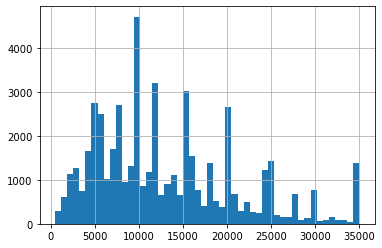

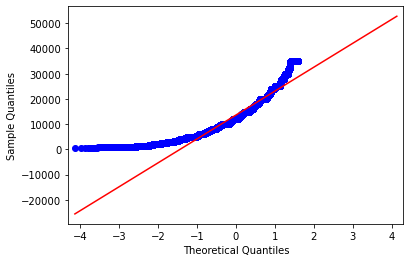

The median of funded_amount is: 12000.0
The mean of funded_amount is: 13229.50911682024
The skew of funded_amount is: 0.8217873460284143
count    51224.000000
mean     13229.509117
std       8019.017599
min        500.000000
25%       7000.000000
50%      12000.000000
75%      18000.000000
max      35000.000000
Name: funded_amount, dtype: float64


In [9]:
# test to see if methods in the Plotter class work 

test_3 = Plotter(payments_df_2, 'funded_amount')
test_3.data_distribution()

In [10]:
# class made which can cause various dataframe transformations 

class DataFrameTransform():
    def __init__(self,dataframe,column):
        self.dataframe = dataframe
        self.column = column
        
    def impute_median(self):
        self.dataframe[self.column] = self.dataframe[self.column].fillna(self.dataframe[self.column].median())
        
    def impute_mean(self):
        self.dataframe[self.column] = self.dataframe[self.column].fillna(self.dataframe[self.column].mean())
        
    def impute_value(self, value):
        self.dataframe[self.column] = self.dataframe[self.column].fillna(value)

    def drop_date_nulls(self):
        self.dataframe[self.column] = self.dataframe[self.column].replace('', pd.NaT)
        self.dataframe = self.dataframe.dropna(axis=0, subset=[self.column], inplace=True)
        
    def log_transform(self):
        self.dataframe[self.column] = self.dataframe[self.column].map(lambda i: np.log(i) if i > 0 else 0)
        
    def boxcox_transform(self):
        boxcox_pop = self.dataframe[self.column]
        transformed_data, lambda_value = stats.boxcox(boxcox_pop)
        self.dataframe[self.column] = transformed_data 
        
    def yeojohnson_transform(self):
        yeojohnson_pop = self.dataframe[self.column]
        transformed_data, lambda_value = stats.yeojohnson(yeojohnson_pop)
        self.dataframe[self.column] = transformed_data

    def remove_outliers(self):
        Q1 = self.dataframe[self.column].quantile(0.25)
        Q3 = self.dataframe[self.column].quantile(0.75)
        IQR = Q3 - Q1
        outliers = self.dataframe[(self.dataframe[self.column] < (Q1 - 1.5*IQR)) | (self.dataframe[self.column] > (Q3 + 1.5*IQR))] 
        self.dataframe.drop(outliers.index, inplace = True)
        



In [11]:
# from the data distribution for funded_amount I have decided to impute the median value of the nulls due to the skew of the data 

test_4 = DataFrameTransform(payments_df_2, 'funded_amount')
test_4.impute_median()

## I will also need to impute or remove nulls for the following columns: 
- term
- int_rate
- employment_length
- last_payment_date
- last_credit_pull_date
- collections_12_mths_ex_med  


Statistic=16516.551, p=0.000


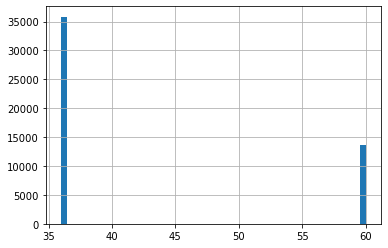

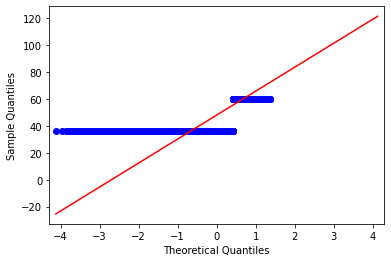

The median of term is: 36.0
The mean of term is: 42.60619907398047
The skew of term is: 1.0063869691734089
count    49459.000000
mean        42.606199
std         10.719573
min         36.000000
25%         36.000000
50%         36.000000
75%         60.000000
max         60.000000
Name: term, dtype: float64


In [12]:
# term distribution 
# imputation will either need to be 36 or 60  

term_distribution = Plotter (payments_df_2, 'term')
term_distribution.data_distribution()


In [13]:
# originally used the summary_plot method to see if term was strongly linked to another value to see if we could impute based off that 
# summary plot not called again for efficiency - pair plots uploaded to git hub seperately from the notebook  
# no correlation between term and the other values therefore will impute the mode of 36 for the nulls

term_impute = DataFrameTransform(payments_df_2, 'term')
term_impute.impute_value(36)

Statistic=1421.934, p=0.000


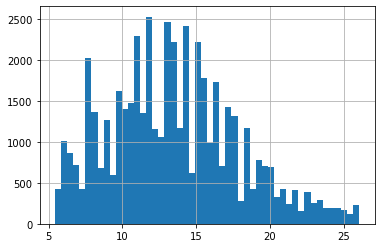

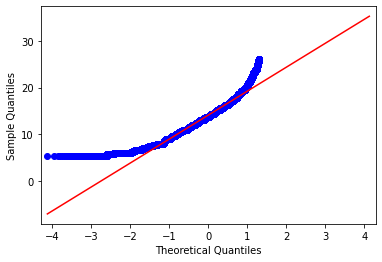

The median of int_rate is: 13.16
The mean of int_rate is: 13.507328482327546
The skew of int_rate is: 0.41203240981473305
count    49062.000000
mean        13.507328
std          4.392893
min          5.420000
25%         10.370000
50%         13.160000
75%         16.200000
max         26.060000
Name: int_rate, dtype: float64


In [14]:
# int rate distribution 
int_rate_dist = Plotter (payments_df_2, 'int_rate')
int_rate_dist.data_distribution()

In [15]:
# int rate impute
int_rate_impute = DataFrameTransform(payments_df_2,'int_rate')
int_rate_impute.impute_mean()
# mean chosen for imputation as data is less skewed

Statistic=265815.107, p=0.000


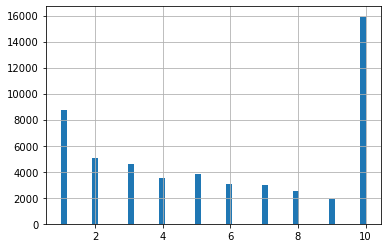

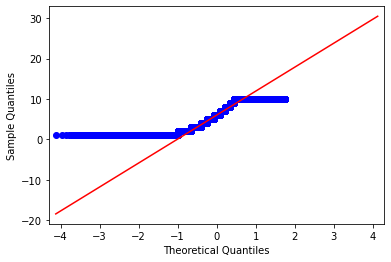

The median of employment_length is: 6.0
The mean of employment_length is: 5.7873467273041275
The skew of employment_length is: -0.030887781130908728
count    52113.000000
mean         5.787347
std          3.508065
min          1.000000
25%          2.000000
50%          6.000000
75%         10.000000
max         10.000000
Name: employment_length, dtype: float64


In [16]:
# employment_length distribution 
employment_length_dist = Plotter (payments_df_2, 'employment_length')
employment_length_dist.data_distribution()


In [17]:
# employment_length impute
employment_length_impute = DataFrameTransform(payments_df_2,'employment_length')
employment_length_impute.impute_median()
# data may not be the most accurate as <1 year converted to 1 and >10 years converted to 10 in intial data type conversion.
# since the largest and second largest counts are for 10 & 1 respectively which are two ends of the data the middle was picked to not bias the data
# this has the draw back of overinflating the number of people employed for 6 years 
# the mean was not picked for imputation as the data for this column should be an integer value 

In [18]:
# for the dates the distribution methods will not work so I will look at the unique values for the data
# this is in case there is just one date with an overwhelming majority of values then we can just impute that value for the missing dates   
unique_last_payment_dates = DataFrameInfo(payments_df_2,'last_payment_date')
unique_last_payment_dates.num_unique_values()

2022-01-01    15569
2021-12-01     5040
2020-12-01     1023
2020-10-01     1020
2021-07-01     1013
              ...  
2014-04-01       10
2014-03-01        8
2014-02-01        3
2014-01-01        3
2013-12-01        1
Name: last_payment_date, Length: 98, dtype: int64


In [19]:
# there are quite a few possible last_payment dates
# while 2022-01-01 is the most prevelant, there are still a substantial number of counts for other dates
# instead of imputing I will drop null rows as they only account ~ 0.13% of the data 
last_payment_date_drop_nulls = DataFrameTransform(payments_df_2,'last_payment_date')
last_payment_date_drop_nulls.drop_date_nulls()


In [20]:
# see how many unique dates there are for last_credit_pull_date  
unique_last_credit_pull_date = DataFrameInfo(payments_df_2,'last_credit_pull_date')
unique_last_credit_pull_date.num_unique_values()

2022-01-01    32110
2021-12-01     1458
2021-11-01      909
2021-10-01      874
2021-09-01      849
              ...  
2013-07-01        1
2013-12-01        1
2013-10-01        1
2014-05-01        1
2014-02-01        1
Name: last_credit_pull_date, Length: 101, dtype: int64


In [21]:
# I will just drop the missing rows since there are multiple possible dates and I would only be getting rid of 7 rows
last_credit_pull_date_drop_nulls = DataFrameTransform(payments_df_2,'last_credit_pull_date')
last_credit_pull_date_drop_nulls.drop_date_nulls()


Statistic=118836.821, p=0.000


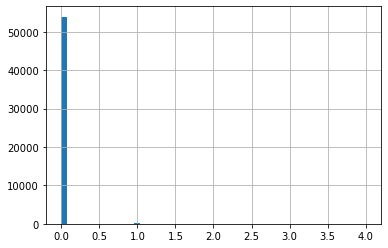

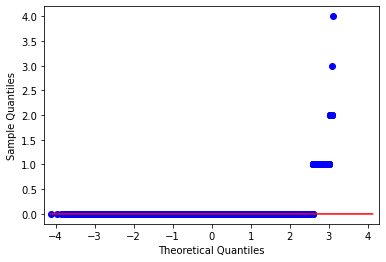

The median of collections_12_mths_ex_med is: 0.0
The mean of collections_12_mths_ex_med is: 0.004195933456561923
The skew of collections_12_mths_ex_med is: 20.29806369008403
count    54100.000000
mean         0.004196
std          0.070913
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: collections_12_mths_ex_med, dtype: float64


In [22]:
# distribution collections_12_mths_ex_med
collections_12_mths_ex_med_dist = Plotter (payments_df_2, 'collections_12_mths_ex_med')
collections_12_mths_ex_med_dist.data_distribution()

In [23]:
# nearly all the data for this column in zero so will just impute that for the nulls
collections_12_mths_ex_med_impute = DataFrameTransform(payments_df_2, 'collections_12_mths_ex_med')
collections_12_mths_ex_med_impute.impute_value(0)


In [24]:
# final check to see if any nulls are left

num_nulls = DataFrameInfo(payments_df_2, payments_df_2.columns[0:])
num_nulls.null_counter()

Index(['id', 'member_id', 'loan_amount', 'funded_amount', 'funded_amount_inv',
       'term', 'int_rate', 'instalment', 'grade', 'sub_grade',
       'employment_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_date', 'loan_status', 'payment_plan',
       'purpose', 'dti', 'delinq_2yrs', 'earliest_credit_line',
       'inq_last_6mths', 'open_accounts', 'total_accounts', 'out_prncp',
       'out_prncp_inv', 'total_payment', 'total_payment_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_payment_date', 'last_payment_amount',
       'last_credit_pull_date', 'collections_12_mths_ex_med', 'policy_code',
       'application_type'],
      dtype='object'): Number of nulls: id                            0
member_id                     0
loan_amount                   0
funded_amount                 0
funded_amount_inv             0
term                          0
int_rate                      

No nulls after imputing data and deleting rows

Next need to transform the data as the data for many columns is heavily skewed.


In [25]:
# data will be transformed in a copy of the data frame as the data analysis in the later steps may not be possible on the transformed data
payments_df_3 = payments_df_2.copy()

In [26]:
# first need to check the skewness of the columns 

skewness_of_all_columns_before = DataFrameInfo(payments_df_3, payments_df_3.columns[0:])
skewness_of_all_columns_before.skewness()


skewness of Index(['id', 'member_id', 'loan_amount', 'funded_amount', 'funded_amount_inv',
       'term', 'int_rate', 'instalment', 'grade', 'sub_grade',
       'employment_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_date', 'loan_status', 'payment_plan',
       'purpose', 'dti', 'delinq_2yrs', 'earliest_credit_line',
       'inq_last_6mths', 'open_accounts', 'total_accounts', 'out_prncp',
       'out_prncp_inv', 'total_payment', 'total_payment_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_payment_date', 'last_payment_amount',
       'last_credit_pull_date', 'collections_12_mths_ex_med', 'policy_code',
       'application_type'],
      dtype='object'): id                             2.370227
member_id                      2.205248
loan_amount                    0.804922
funded_amount                  0.869634
funded_amount_inv              0.813376
term                       

Need a threshold where if the skewness of the column is greater than this value it will be transformed
 1 will be used as the threshold but only when it is appropriate to transform the data i.e won't change member_id eventhough its above the threshold as distribution of the ID's is irrelevant and we want to retain the unique ID's 


In [27]:
# test to see if transformation method works. annual_inc is above the skewness threshold so will need to be transformed so it makes a good test column
annual_inc_transform = DataFrameTransform(payments_df_3, 'annual_inc')
annual_inc_transform.boxcox_transform()

Statistic=80373.209, p=0.000


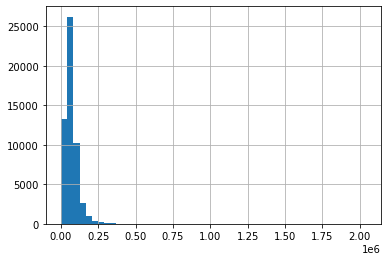

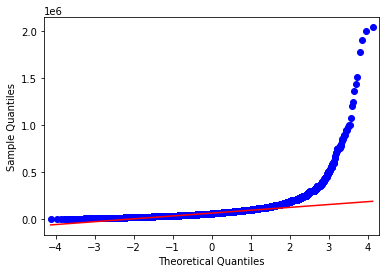

The median of annual_inc is: 61023.0
The mean of annual_inc is: 72233.46322524057
The skew of annual_inc is: 8.717499605870014
count    5.415100e+04
mean     7.223346e+04
std      5.160063e+04
min      3.300000e+03
25%      4.500000e+04
50%      6.102300e+04
75%      8.600000e+04
max      2.039784e+06
Name: annual_inc, dtype: float64
Statistic=1238.992, p=0.000


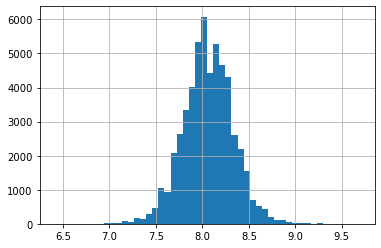

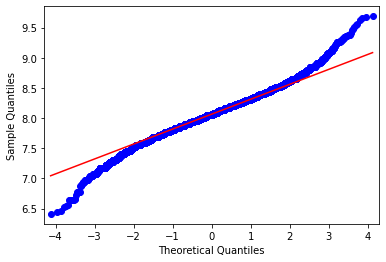

The median of annual_inc is: 8.056567766910122
The mean of annual_inc is: 8.062138536618727
The skew of annual_inc is: -0.01208067397401199
count    54151.000000
mean         8.062139
std          0.272941
min          6.412875
25%          7.898124
50%          8.056568
75%          8.231601
max          9.687277
Name: annual_inc, dtype: float64


In [28]:
# comparison of the skew before and after transformation 
annual_inc_before = Plotter(payments_df_2,'annual_inc')
annual_inc_after = Plotter(payments_df_3,'annual_inc')
annual_inc_before.data_distribution()
annual_inc_after.data_distribution()

Can see visually and quantitively see that skewness has been reduced after transformation.

## Further columns to transform:
- instalment
- open_accounts
- total_payment
- total_payment_inv
- total_rec_prncp
- total_rec_int



In [29]:
instalment_transform = DataFrameTransform(payments_df_3, 'instalment')
instalment_transform.boxcox_transform()

Statistic=7272.241, p=0.000


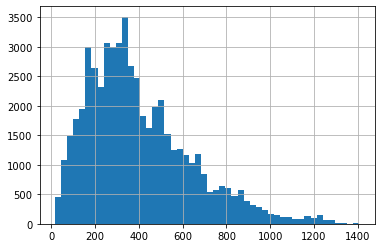

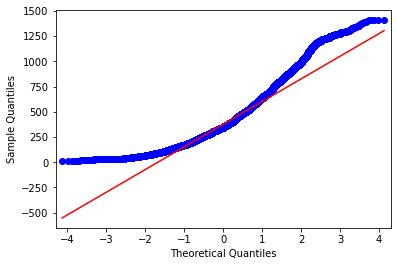

The median of instalment is: 347.15
The mean of instalment is: 400.16004247382216
The skew of instalment is: 0.9965721690437305
count    54151.000000
mean       400.160042
std        238.875513
min         15.670000
25%        224.430000
50%        347.150000
75%        527.825000
max       1407.010000
Name: instalment, dtype: float64
Statistic=203.247, p=0.000


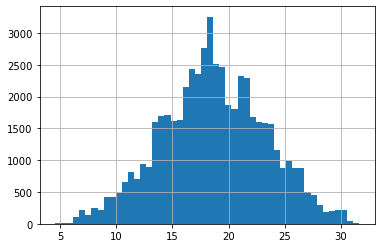

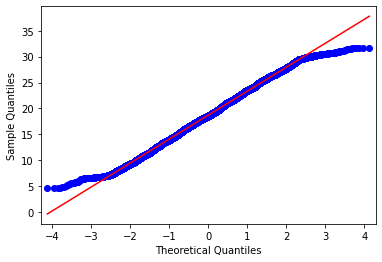

The median of instalment is: 18.538606867238855
The mean of instalment is: 18.67633915340329
The skew of instalment is: -0.020712923291849768
count    54151.000000
mean        18.676339
std          4.636603
min          4.553739
25%         15.579274
50%         18.538607
75%         21.825696
max         31.618887
Name: instalment, dtype: float64


In [30]:
# comparison of the skew 
instalment_before = Plotter(payments_df_2,'instalment')
instalment_after = Plotter(payments_df_3,'instalment')
instalment_before.data_distribution()
instalment_after.data_distribution()

In [31]:
# transformations have successfully worked on two columns. 
# to increase efficiency a function can be used to do the rest of the transforms in one go.
# switched to yeojohnson from box cox due to possible non-positive values breaking the function. 

# function to transform multiple columns

def transform_multi(dataframe, *args):
    columns_to_transform = args
    for columns in columns_to_transform:
        column_transform = DataFrameTransform(dataframe, columns)
        column_transform.yeojohnson_transform()

#function to compare the skews of these columns before and after transformation 

def compare_skews(dataframe1, dataframe2, *args):
    columns_to_transform = args
    for columns in columns_to_transform:
        skew_before = Plotter(dataframe1, columns)
        skew_after = Plotter(dataframe2, columns)
        skew_before.data_distribution()
        skew_after.data_distribution()
        

In [32]:
# function run on the remaning columns that need transforming 

transform_multi(payments_df_3, 'open_accounts', 'total_payment', 'total_payment_inv', 'total_rec_prncp', 'total_rec_int')

Statistic=9774.420, p=0.000


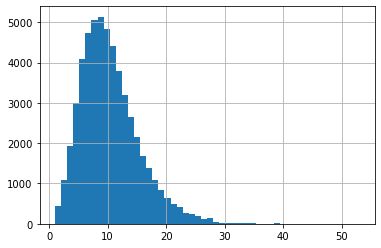

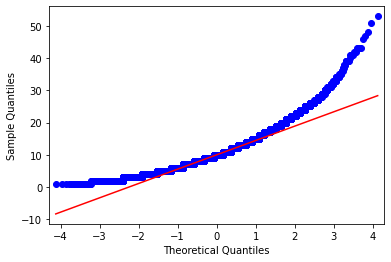

The median of open_accounts is: 10.0
The mean of open_accounts is: 10.563572233199757
The skew of open_accounts is: 1.0591835802494733
count    54151.000000
mean        10.563572
std          4.797289
min          1.000000
25%          7.000000
50%         10.000000
75%         13.000000
max         53.000000
Name: open_accounts, dtype: float64
Statistic=10.771, p=0.005


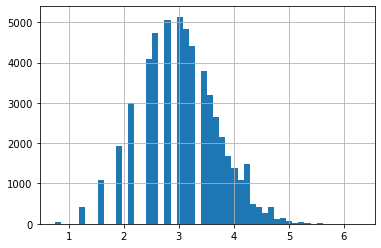

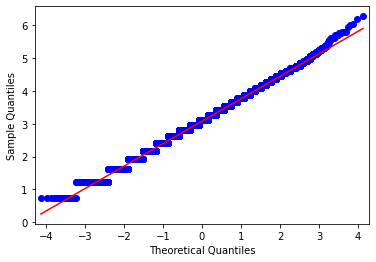

The median of open_accounts is: 3.1276243824521655
The mean of open_accounts is: 3.1007527532884667
The skew of open_accounts is: 0.0018142275313754676
count    54151.000000
mean         3.100753
std          0.688212
min          0.746819
25%          2.614983
50%          3.127624
75%          3.539602
max          6.279693
Name: open_accounts, dtype: float64
Statistic=11271.968, p=0.000


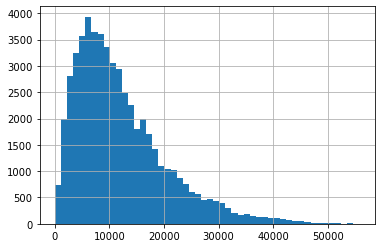

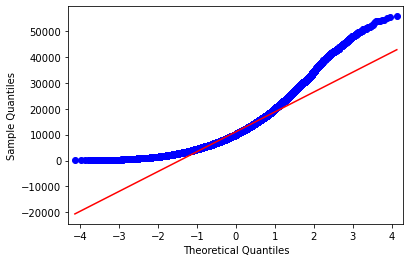

The median of total_payment is: 10123.08
The mean of total_payment is: 12094.400013372855
The skew of total_payment is: 1.2698752968451772
count    54151.000000
mean     12094.400013
std       8386.475714
min         33.730000
25%       5911.490000
50%      10123.080000
75%      16284.787047
max      55758.222084
Name: total_payment, dtype: float64
Statistic=94.654, p=0.000


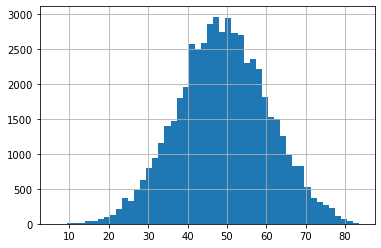

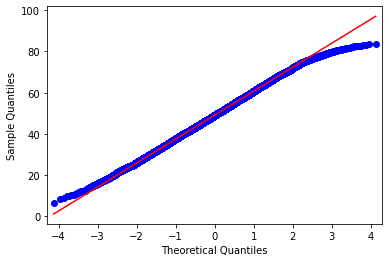

The median of total_payment is: 48.97584330511961
The mean of total_payment is: 49.036928102588796
The skew of total_payment is: -0.013836103211455529
count    54151.000000
mean        49.036928
std         11.454486
min          6.299827
25%         41.231055
50%         48.975843
75%         56.933749
max         83.621577
Name: total_payment, dtype: float64
Statistic=11098.126, p=0.000


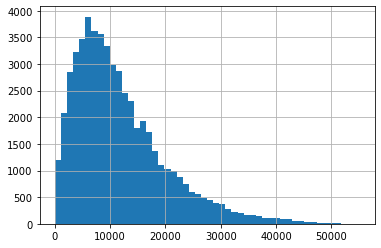

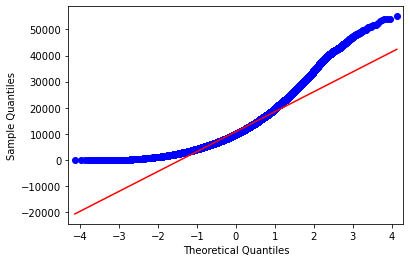

The median of total_payment_inv is: 9849.1
The mean of total_payment_inv is: 11803.740359734875
The skew of total_payment_inv is: 1.257870048149293
count    54151.000000
mean     11803.740360
std       8359.370538
min          0.000000
25%       5677.165000
50%       9849.100000
75%      15990.400000
max      55061.000000
Name: total_payment_inv, dtype: float64
Statistic=0.785, p=0.675


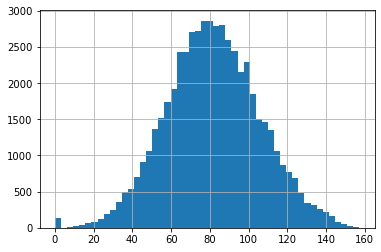

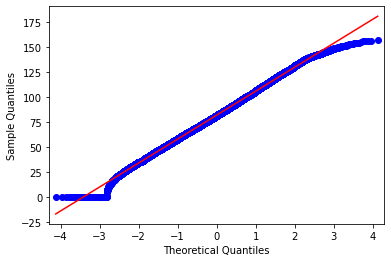

The median of total_payment_inv is: 81.14617337787453
The mean of total_payment_inv is: 81.63188042810222
The skew of total_payment_inv is: 0.005207921004141266
count    54151.000000
mean        81.631880
std         24.048225
min          0.000000
25%         65.506625
50%         81.146173
75%         97.844343
max        157.119577
Name: total_payment_inv, dtype: float64
Statistic=10785.991, p=0.000


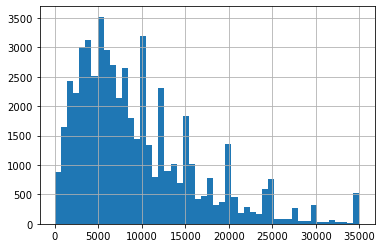

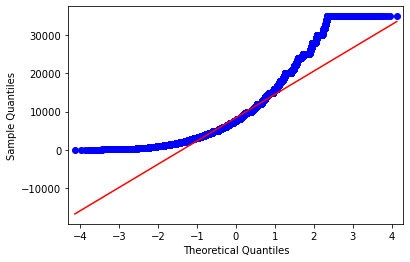

The median of total_rec_prncp is: 7663.39
The mean of total_rec_prncp is: 9420.051605141323
The skew of total_rec_prncp is: 1.2626785390807123
count    54151.000000
mean      9420.051605
std       6954.417960
min          0.000000
25%       4278.835000
50%       7663.390000
75%      12525.000000
max      35000.020000
Name: total_rec_prncp, dtype: float64
Statistic=140.696, p=0.000


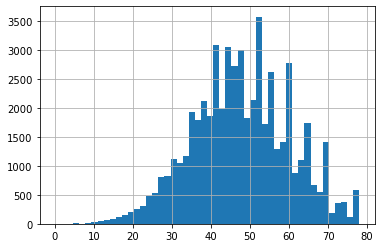

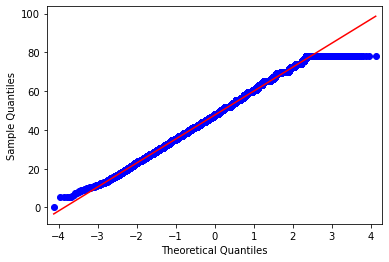

The median of total_rec_prncp is: 47.66965486509342
The mean of total_rec_prncp is: 47.80200343561982
The skew of total_rec_prncp is: -0.017648373012225337
count    54151.000000
mean        47.802003
std         12.470411
min          0.000000
25%         39.314164
50%         47.669655
75%         55.975613
max         77.993025
Name: total_rec_prncp, dtype: float64
Statistic=24843.087, p=0.000


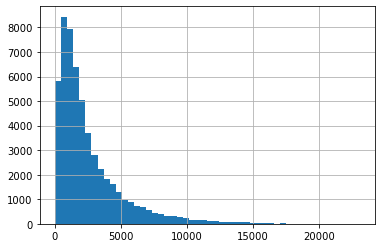

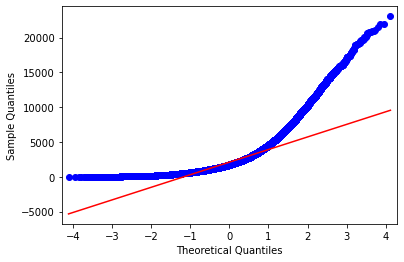

The median of total_rec_int is: 1737.82
The mean of total_rec_int is: 2581.3139978947884
The skew of total_rec_int is: 2.2045848938701638
count    54151.000000
mean      2581.313998
std       2581.745241
min          6.220000
25%        892.130000
50%       1737.820000
75%       3326.635000
max      23062.450000
Name: total_rec_int, dtype: float64
Statistic=0.147, p=0.929


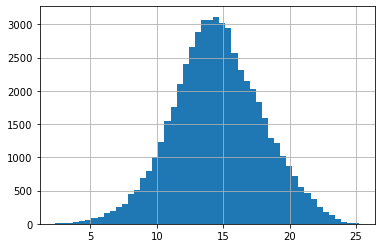

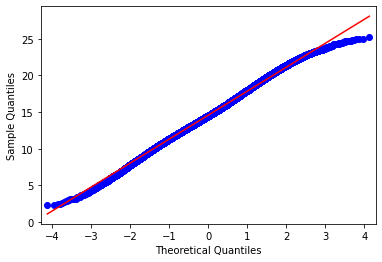

The median of total_rec_int is: 14.495905081680835
The mean of total_rec_int is: 14.573868050546688
The skew of total_rec_int is: 0.0012930933550431073
count    54151.000000
mean        14.573868
std          3.344593
min          2.329915
25%         12.381882
50%         14.495905
75%         16.786804
max         25.241583
Name: total_rec_int, dtype: float64


In [33]:
# compare the distributions before and after transformation

compare_skews(payments_df_2, payments_df_3, 'open_accounts', 'total_payment', 'total_payment_inv', 'total_rec_prncp', 'total_rec_int' )

Skewness has been reduced on the targeted columns. 

In [34]:
# skewness of all columns checked again 
skewness_of_all_columns_after = DataFrameInfo(payments_df_3, payments_df_3.columns[0:])
skewness_of_all_columns_after.skewness()

skewness of Index(['id', 'member_id', 'loan_amount', 'funded_amount', 'funded_amount_inv',
       'term', 'int_rate', 'instalment', 'grade', 'sub_grade',
       'employment_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_date', 'loan_status', 'payment_plan',
       'purpose', 'dti', 'delinq_2yrs', 'earliest_credit_line',
       'inq_last_6mths', 'open_accounts', 'total_accounts', 'out_prncp',
       'out_prncp_inv', 'total_payment', 'total_payment_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_payment_date', 'last_payment_amount',
       'last_credit_pull_date', 'collections_12_mths_ex_med', 'policy_code',
       'application_type'],
      dtype='object'): id                             2.370227
member_id                      2.205248
loan_amount                    0.804922
funded_amount                  0.869634
funded_amount_inv              0.813376
term                       

Next need to remove the outliers from the transformed data.

Statistic=4576.014, p=0.000


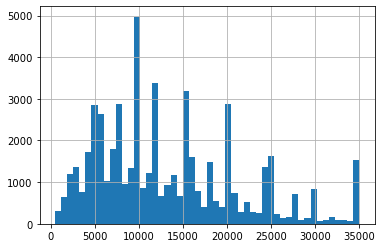

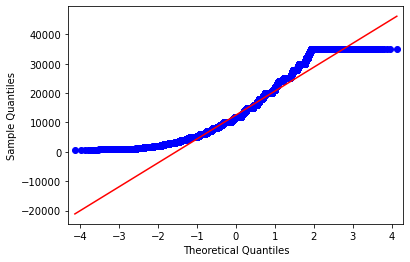

The median of loan_amount is: 12000.0
The mean of loan_amount is: 13338.588853391442
The skew of loan_amount is: 0.8049220181025606
count    54151.000000
mean     13338.588853
std       8080.919795
min        500.000000
25%       7000.000000
50%      12000.000000
75%      18000.000000
max      35000.000000
Name: loan_amount, dtype: float64
loan_amount 25th percentile: 7000.0
loan_amount 75th percentile: 18000.0
loan_amount IQR: 11000.0
loan_amount number of outliers: 1499
loan_amount percentage of outliers: 2.7681852597366623
loan_amount Outliers:              id  member_id  loan_amount  funded_amount  funded_amount_inv  \
21     38655834   41439638        35000        35000.0       35000.000000   
36     38655417   41439213        35000        12000.0       35000.000000   
37     38655413   41439208        35000        35000.0       35000.000000   
64     38654574   41438319        35000        35000.0       35000.000000   
149    38635990   41419794        35000        12000.0       

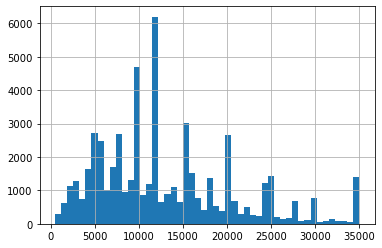

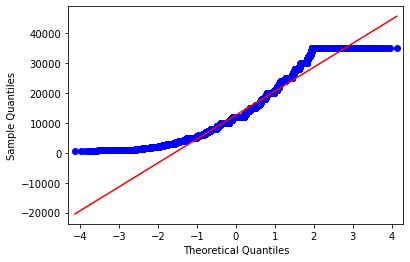

The median of funded_amount is: 12000.0
The mean of funded_amount is: 13166.223153773706
The skew of funded_amount is: 0.8696343258205478
count    54151.000000
mean     13166.223154
std       7797.381748
min        500.000000
25%       7200.000000
50%      12000.000000
75%      18000.000000
max      35000.000000
Name: funded_amount, dtype: float64
funded_amount 25th percentile: 7200.0
funded_amount 75th percentile: 18000.0
funded_amount IQR: 10800.0
funded_amount number of outliers: 1390
funded_amount percentage of outliers: 2.5668962715369985
funded_amount Outliers:              id  member_id  loan_amount  funded_amount  funded_amount_inv  \
21     38655834   41439638        35000        35000.0       35000.000000   
37     38655413   41439208        35000        35000.0       35000.000000   
64     38654574   41438319        35000        35000.0       35000.000000   
181    38634902   41418676        35000        35000.0       35000.000000   
186    38634766   41418533        35000  

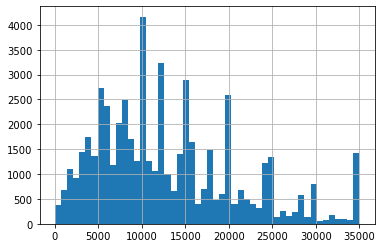

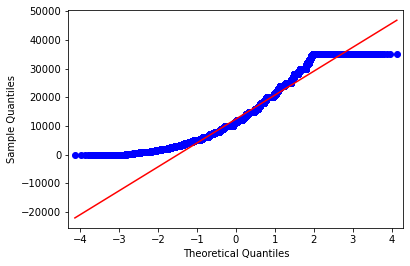

The median of funded_amount_inv is: 11325.0
The mean of funded_amount_inv is: 12958.374670698076
The skew of funded_amount_inv is: 0.8133760847946324
count    54151.000000
mean     12958.374671
std       8098.334274
min          0.000000
25%       6730.246239
50%      11325.000000
75%      18000.000000
max      35000.000000
Name: funded_amount_inv, dtype: float64
funded_amount_inv 25th percentile: 6730.24623856
funded_amount_inv 75th percentile: 18000.0
funded_amount_inv IQR: 11269.753761439999
funded_amount_inv number of outliers: 1283
funded_amount_inv percentage of outliers: 2.3693006592676036
funded_amount_inv Outliers:              id  member_id  loan_amount  funded_amount  funded_amount_inv  \
21     38655834   41439638        35000        35000.0       35000.000000   
36     38655417   41439213        35000        12000.0       35000.000000   
37     38655413   41439208        35000        35000.0       35000.000000   
64     38654574   41438319        35000        35000.0      

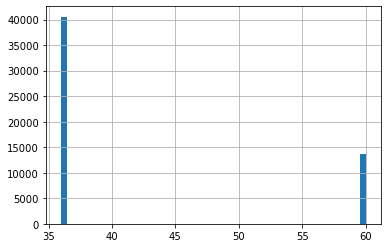

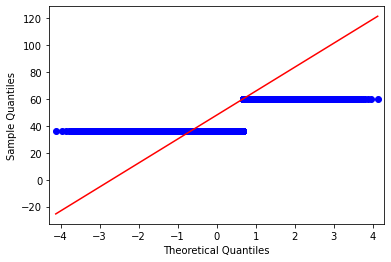

The median of term is: 36.0
The mean of term is: 42.02714631308748
The skew of term is: 1.1477822801014974
count    54151.000000
mean        42.027146
std         10.408027
min         36.000000
25%         36.000000
50%         36.000000
75%         60.000000
max         60.000000
Name: term, dtype: float64
term 25th percentile: 36.0
term 75th percentile: 60.0
term IQR: 24.0
term number of outliers: 0
term percentage of outliers: 0.0
term Outliers: Empty DataFrame
Columns: [id, member_id, loan_amount, funded_amount, funded_amount_inv, term, int_rate, instalment, grade, sub_grade, employment_length, home_ownership, annual_inc, verification_status, issue_date, loan_status, payment_plan, purpose, dti, delinq_2yrs, earliest_credit_line, inq_last_6mths, open_accounts, total_accounts, out_prncp, out_prncp_inv, total_payment, total_payment_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_payment_date, last_payment_amount, last_credit_pull_dat

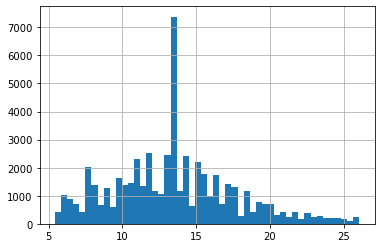

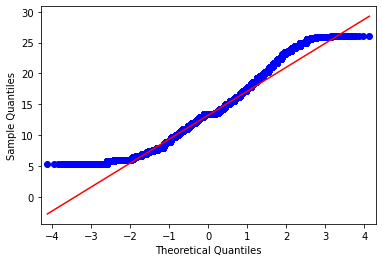

The median of int_rate is: 13.507328482327546
The mean of int_rate is: 13.505845917846443
The skew of int_rate is: 0.43329641641837385
count    54151.000000
mean        13.505846
std          4.178575
min          5.420000
25%         10.650000
50%         13.507328
75%         15.880000
max         26.060000
Name: int_rate, dtype: float64
int_rate 25th percentile: 10.65
int_rate 75th percentile: 15.88
int_rate IQR: 5.23
int_rate number of outliers: 917
int_rate percentage of outliers: 1.6934128640283652
int_rate Outliers:              id  member_id  loan_amount  funded_amount  funded_amount_inv  \
25     38655682   41439481        15050        12000.0            15050.0   
105    38645280   41429075        22475        22475.0            22475.0   
112    38645110   41428901         3000         3000.0             3000.0   
125    38644604   41428358        26000        26000.0            26000.0   
182    38634881   41418652        10900        10900.0            10900.0   
...      

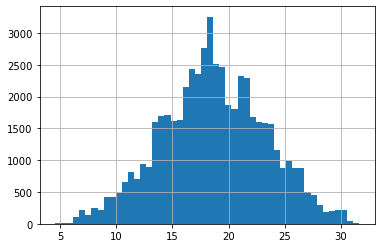

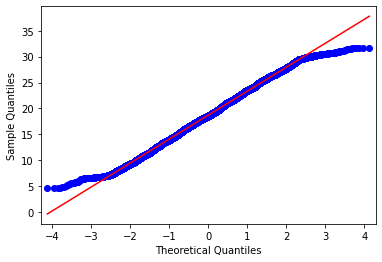

The median of instalment is: 18.538606867238855
The mean of instalment is: 18.67633915340329
The skew of instalment is: -0.020712923291849768
count    54151.000000
mean        18.676339
std          4.636603
min          4.553739
25%         15.579274
50%         18.538607
75%         21.825696
max         31.618887
Name: instalment, dtype: float64
instalment 25th percentile: 15.579274451713163
instalment 75th percentile: 21.82569566834911
instalment IQR: 6.246421216635946
instalment number of outliers: 40
instalment percentage of outliers: 0.07386751860538125
instalment Outliers:              id  member_id  loan_amount  funded_amount  funded_amount_inv  \
607    38584295   41368020        35000        35000.0       35000.000000   
3863   37610383   40373124        35000        35000.0       35000.000000   
5488   10069292   11920905        35000        35000.0       34975.000000   
6750    9796145   11648170        35000        35000.0       35000.000000   
6935    9777451   11629335 

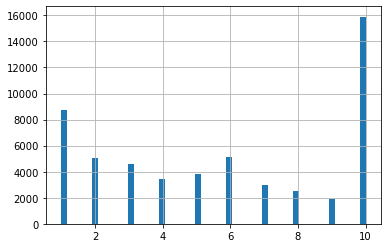

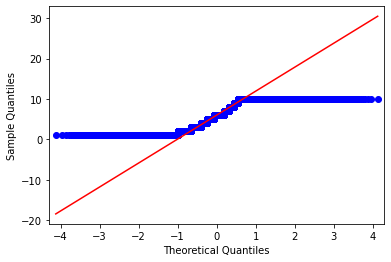

The median of employment_length is: 6.0
The mean of employment_length is: 5.797566065261953
The skew of employment_length is: -0.03950845750136528
count    54151.000000
mean         5.797566
std          3.439306
min          1.000000
25%          2.000000
50%          6.000000
75%         10.000000
max         10.000000
Name: employment_length, dtype: float64
employment_length 25th percentile: 2.0
employment_length 75th percentile: 10.0
employment_length IQR: 8.0
employment_length number of outliers: 0
employment_length percentage of outliers: 0.0
employment_length Outliers: Empty DataFrame
Columns: [id, member_id, loan_amount, funded_amount, funded_amount_inv, term, int_rate, instalment, grade, sub_grade, employment_length, home_ownership, annual_inc, verification_status, issue_date, loan_status, payment_plan, purpose, dti, delinq_2yrs, earliest_credit_line, inq_last_6mths, open_accounts, total_accounts, out_prncp, out_prncp_inv, total_payment, total_payment_inv, total_rec_prncp, tot

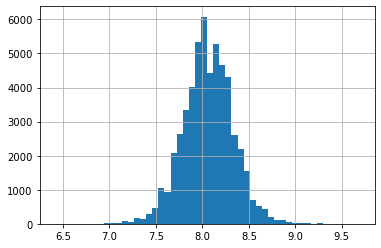

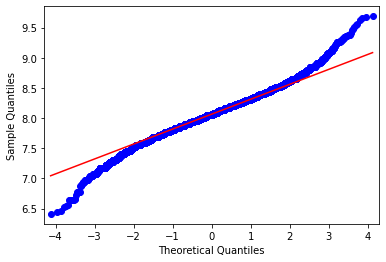

The median of annual_inc is: 8.056567766910122
The mean of annual_inc is: 8.062138536618727
The skew of annual_inc is: -0.01208067397401199
count    54151.000000
mean         8.062139
std          0.272941
min          6.412875
25%          7.898124
50%          8.056568
75%          8.231601
max          9.687277
Name: annual_inc, dtype: float64
annual_inc 25th percentile: 7.898124224523094
annual_inc 75th percentile: 8.231600857911454
annual_inc IQR: 0.33347663338836053
annual_inc number of outliers: 1133
annual_inc percentage of outliers: 2.092297464497424
annual_inc Outliers:              id  member_id  loan_amount  funded_amount  funded_amount_inv  \
6      38656110   41439916         6675         6675.0             6675.0   
43     38655125   41438911        15000        15000.0            15000.0   
66     38654525   41438266        28000        28000.0            28000.0   
112    38645110   41428901         3000         3000.0             3000.0   
237    38625386   41409165  

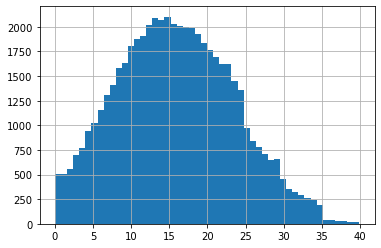

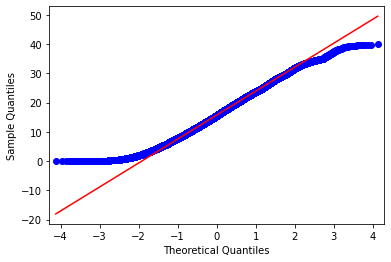

The median of dti is: 15.6
The mean of dti is: 15.870900814389474
The skew of dti is: 0.18910057534680505
count    54151.000000
mean        15.870901
std          7.621362
min          0.000000
25%         10.210000
50%         15.600000
75%         21.270000
max         39.910000
Name: dti, dtype: float64
dti 25th percentile: 10.21
dti 75th percentile: 21.27
dti IQR: 11.059999999999999
dti number of outliers: 60
dti percentage of outliers: 0.11080127790807189
dti Outliers:             id  member_id  loan_amount  funded_amount  funded_amount_inv  \
62    38654661   41438416        13600        13600.0            13600.0   
83    38645937   41429742         1325         1325.0             1325.0   
86    38645787   41429591         8000         8000.0             8000.0   
128   38644550   41428300         8000         8000.0             8000.0   
145   38636095   41419900        21000        21000.0            21000.0   
201   38634247   41417969        20000        20000.0            

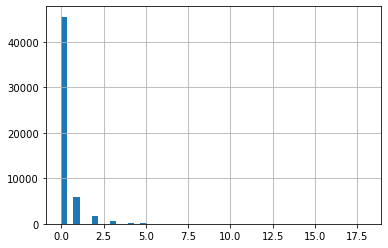

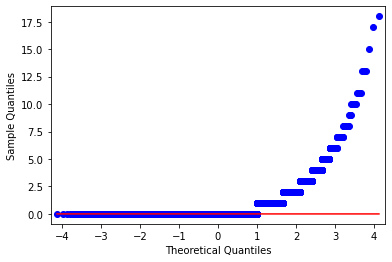

The median of delinq_2yrs is: 0.0
The mean of delinq_2yrs is: 0.24165758711750476
The skew of delinq_2yrs is: 5.376384516017939
count    54151.000000
mean         0.241658
std          0.706384
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         18.000000
Name: delinq_2yrs, dtype: float64
delinq_2yrs 25th percentile: 0.0
delinq_2yrs 75th percentile: 0.0
delinq_2yrs IQR: 0.0
delinq_2yrs number of outliers: 8587
delinq_2yrs percentage of outliers: 15.85750955661022
delinq_2yrs Outliers:              id  member_id  loan_amount  funded_amount  funded_amount_inv  \
0      38676116   41461848         8000         8000.0             8000.0   
5      38656111   41439917         2525         2525.0             2525.0   
12     38656003   41439808         6000         6000.0             6000.0   
16     38655917   41439721        12000        12000.0            12000.0   
17     38655869   41439673        18825        18825.0            18825.0   


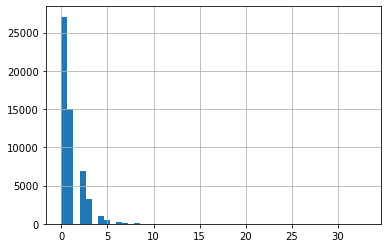

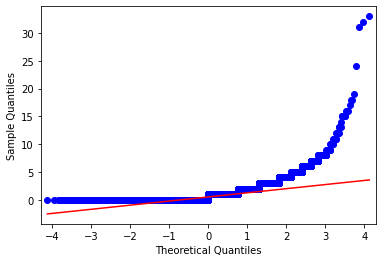

The median of inq_last_6mths is: 0.0
The mean of inq_last_6mths is: 0.8930767668187106
The skew of inq_last_6mths is: 3.253522804381087
count    54151.000000
mean         0.893077
std          1.260589
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         33.000000
Name: inq_last_6mths, dtype: float64
inq_last_6mths 25th percentile: 0.0
inq_last_6mths 75th percentile: 1.0
inq_last_6mths IQR: 1.0
inq_last_6mths number of outliers: 5217
inq_last_6mths percentage of outliers: 9.634171114106849
inq_last_6mths Outliers:              id  member_id  loan_amount  funded_amount  funded_amount_inv  \
17     38655869   41439673        18825        18825.0            18825.0   
22     38655809   41439612        10000        10000.0            10000.0   
38     38655401   41439196        25000        25000.0            25000.0   
45     38655085   41438867        18400        18400.0            18400.0   
57     38654802   41438568        14350        1

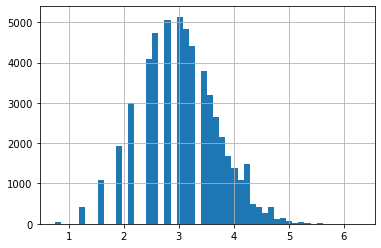

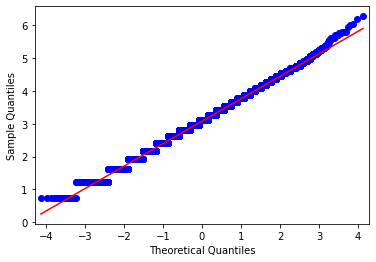

The median of open_accounts is: 3.1276243824521655
The mean of open_accounts is: 3.1007527532884667
The skew of open_accounts is: 0.0018142275313754676
count    54151.000000
mean         3.100753
std          0.688212
min          0.746819
25%          2.614983
50%          3.127624
75%          3.539602
max          6.279693
Name: open_accounts, dtype: float64
open_accounts 25th percentile: 2.614983319217588
open_accounts 75th percentile: 3.539602173267412
open_accounts IQR: 0.9246188540498239
open_accounts number of outliers: 227
open_accounts percentage of outliers: 0.4191981680855386
open_accounts Outliers:              id  member_id  loan_amount  funded_amount  funded_amount_inv  \
359    38614238   41397953        15000        15000.0            15000.0   
418    38604822   41388569         6800         6800.0             6800.0   
496    38594944   41378707        13800        13800.0            13800.0   
548    38585910   41369706        19600        19600.0            19600.0

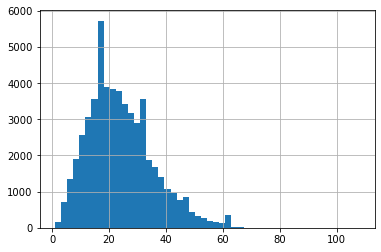

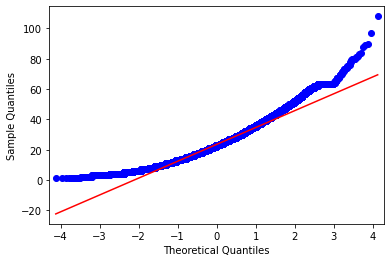

The median of total_accounts is: 23.0
The mean of total_accounts is: 24.17613709811453
The skew of total_accounts is: 0.7790400286166349
count    54151.000000
mean        24.176137
std         11.585073
min          1.000000
25%         16.000000
50%         23.000000
75%         31.000000
max        108.000000
Name: total_accounts, dtype: float64
total_accounts 25th percentile: 16.0
total_accounts 75th percentile: 31.0
total_accounts IQR: 15.0
total_accounts number of outliers: 1010
total_accounts percentage of outliers: 1.8651548447858763
total_accounts Outliers:              id  member_id  loan_amount  funded_amount  funded_amount_inv  \
41     38655201   41438988         5000         5000.0        5000.000000   
208    38626412   41410217        17600        17600.0       17600.000000   
247    38625265   41409040        28000        28000.0       28000.000000   
263    38624908   41408659        30000        30000.0       30000.000000   
359    38614238   41397953        15000    

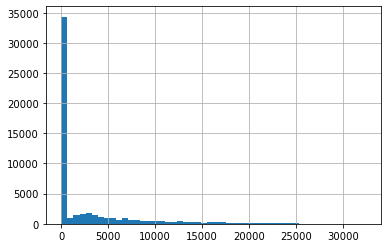

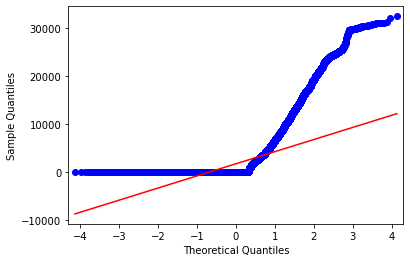

The median of out_prncp is: 0.0
The mean of out_prncp is: 2757.5797795054514
The skew of out_prncp is: 2.35405079479137
count    54151.000000
mean      2757.579780
std       5156.777392
min          0.000000
25%          0.000000
50%          0.000000
75%       3408.470000
max      32399.940000
Name: out_prncp, dtype: float64
out_prncp 25th percentile: 0.0
out_prncp 75th percentile: 3408.4700000000003
out_prncp IQR: 3408.4700000000003
out_prncp number of outliers: 6497
out_prncp percentage of outliers: 11.99793170947905
out_prncp Outliers:              id  member_id  loan_amount  funded_amount  funded_amount_inv  \
1      38656203   41440010        13200        13200.0            13200.0   
4      38656121   41439927        15000        15000.0            15000.0   
17     38655869   41439673        18825        18825.0            18825.0   
18     38655866   41439670        12000        12000.0            12000.0   
21     38655834   41439638        35000        35000.0            350

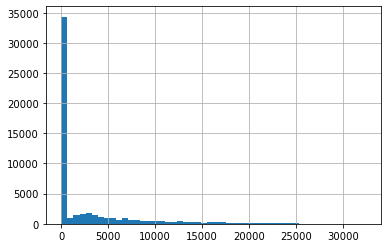

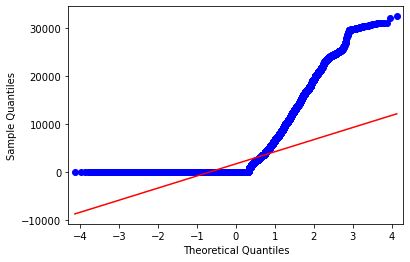

The median of out_prncp_inv is: 0.0
The mean of out_prncp_inv is: 2756.181691750827
The skew of out_prncp_inv is: 2.354471408893565
count    54151.000000
mean      2756.181692
std       5154.926313
min          0.000000
25%          0.000000
50%          0.000000
75%       3403.695000
max      32399.940000
Name: out_prncp_inv, dtype: float64
out_prncp_inv 25th percentile: 0.0
out_prncp_inv 75th percentile: 3403.6949999999997
out_prncp_inv IQR: 3403.6949999999997
out_prncp_inv number of outliers: 6500
out_prncp_inv percentage of outliers: 12.003471773374452
out_prncp_inv Outliers:              id  member_id  loan_amount  funded_amount  funded_amount_inv  \
1      38656203   41440010        13200        13200.0            13200.0   
4      38656121   41439927        15000        15000.0            15000.0   
17     38655869   41439673        18825        18825.0            18825.0   
18     38655866   41439670        12000        12000.0            12000.0   
21     38655834   41439638  

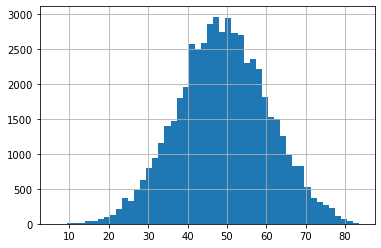

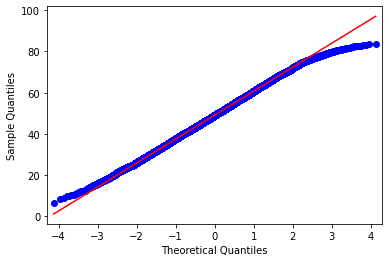

The median of total_payment is: 48.97584330511961
The mean of total_payment is: 49.036928102588796
The skew of total_payment is: -0.013836103211455529
count    54151.000000
mean        49.036928
std         11.454486
min          6.299827
25%         41.231055
50%         48.975843
75%         56.933749
max         83.621577
Name: total_payment, dtype: float64
total_payment 25th percentile: 41.23105497119796
total_payment 75th percentile: 56.93374864728332
total_payment IQR: 15.70269367608536
total_payment number of outliers: 180
total_payment percentage of outliers: 0.3324038337242156
total_payment Outliers:              id  member_id  loan_amount  funded_amount  funded_amount_inv  \
83     38645937   41429742         1325         1325.0        1325.000000   
162    38635567   41419362         1000         1000.0        1000.000000   
255    38625052   41408809         1000         1000.0        1000.000000   
581    38585017   41368782         1000         1000.0        1000.000000  

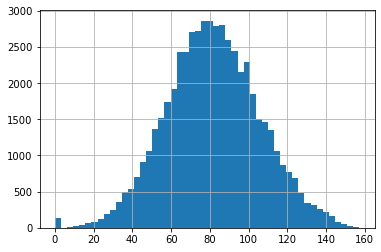

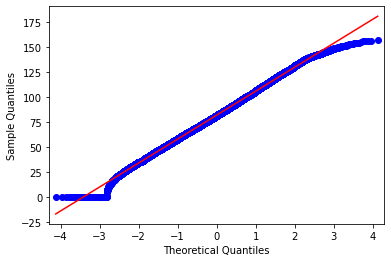

The median of total_payment_inv is: 81.14617337787453
The mean of total_payment_inv is: 81.63188042810222
The skew of total_payment_inv is: 0.005207921004141266
count    54151.000000
mean        81.631880
std         24.048225
min          0.000000
25%         65.506625
50%         81.146173
75%         97.844343
max        157.119577
Name: total_payment_inv, dtype: float64
total_payment_inv 25th percentile: 65.50662496218662
total_payment_inv 75th percentile: 97.84434269884719
total_payment_inv IQR: 32.337717736660565
total_payment_inv number of outliers: 337
total_payment_inv percentage of outliers: 0.622333844250337
total_payment_inv Outliers:              id  member_id  loan_amount  funded_amount  funded_amount_inv  \
2755   38152329   40936094         1500         1500.0             1500.0   
4863   10126511   11978571         3000         3000.0             3000.0   
5488   10069292   11920905        35000        35000.0            34975.0   
6254    9837091   11689028        345

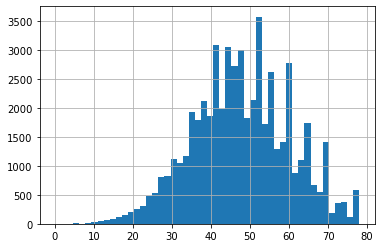

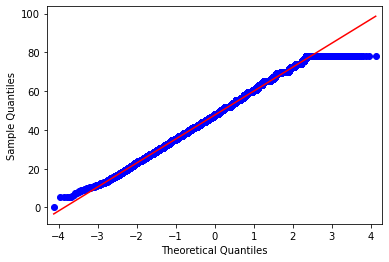

The median of total_rec_prncp is: 47.66965486509342
The mean of total_rec_prncp is: 47.80200343561982
The skew of total_rec_prncp is: -0.017648373012225337
count    54151.000000
mean        47.802003
std         12.470411
min          0.000000
25%         39.314164
50%         47.669655
75%         55.975613
max         77.993025
Name: total_rec_prncp, dtype: float64
total_rec_prncp 25th percentile: 39.31416369815326
total_rec_prncp 75th percentile: 55.97561299094159
total_rec_prncp IQR: 16.661449292788333
total_rec_prncp number of outliers: 187
total_rec_prncp percentage of outliers: 0.34533064948015735
total_rec_prncp Outliers:              id  member_id  loan_amount  funded_amount  funded_amount_inv  \
83     38645937   41429742         1325         1325.0        1325.000000   
967    38534642   41318387        16000        16000.0       16000.000000   
1852   38381495   41165240         1000         1000.0        1000.000000   
2755   38152329   40936094         1500         1500.0

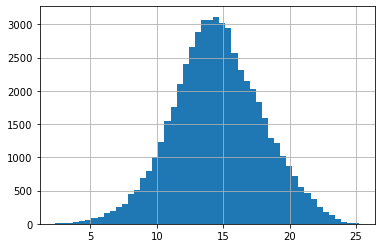

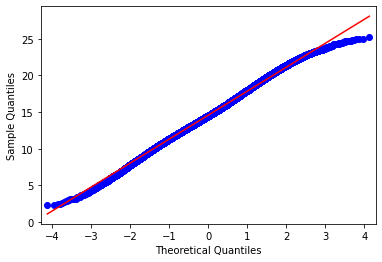

The median of total_rec_int is: 14.495905081680835
The mean of total_rec_int is: 14.573868050546688
The skew of total_rec_int is: 0.0012930933550431073
count    54151.000000
mean        14.573868
std          3.344593
min          2.329915
25%         12.381882
50%         14.495905
75%         16.786804
max         25.241583
Name: total_rec_int, dtype: float64
total_rec_int 25th percentile: 12.381882374705198
total_rec_int 75th percentile: 16.78680422550884
total_rec_int IQR: 4.404921850803641
total_rec_int number of outliers: 414
total_rec_int percentage of outliers: 0.7645288175656959
total_rec_int Outliers:              id  member_id  loan_amount  funded_amount  funded_amount_inv  \
58     38654722   41438479         5375         5375.0             5375.0   
124    38644620   41428375         8050         8050.0             8050.0   
353    38614452   41398185         2500         2500.0             2500.0   
389    38605861   41389647         1500         1500.0             1500.0

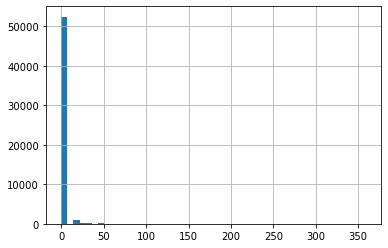

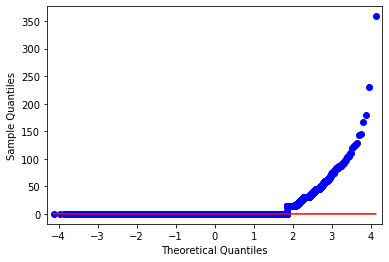

The median of total_rec_late_fee is: 0.0
The mean of total_rec_late_fee is: 0.902843707203239
The skew of total_rec_late_fee is: 13.174553220535644
count    54151.000000
mean         0.902844
std          6.220285
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        358.680000
Name: total_rec_late_fee, dtype: float64
total_rec_late_fee 25th percentile: 0.0
total_rec_late_fee 75th percentile: 0.0
total_rec_late_fee IQR: 0.0
total_rec_late_fee number of outliers: 1761
total_rec_late_fee percentage of outliers: 3.2520175066019092
total_rec_late_fee Outliers:              id  member_id  loan_amount  funded_amount  funded_amount_inv  \
91     38645705   41429508         7000         7000.0             7000.0   
149    38635990   41419794        35000        12000.0            35000.0   
168    38635317   41419102         6000         6000.0             6000.0   
244    38625311   41409088         8125         8125.0             8125.0   
428    

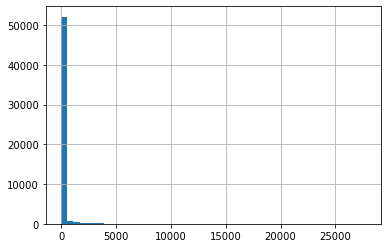

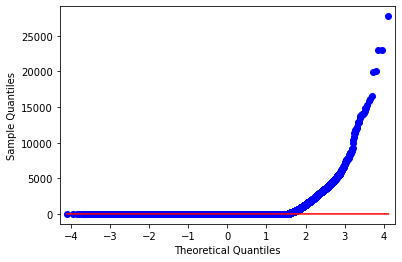

The median of recoveries is: 0.0
The mean of recoveries is: 92.13157621421487
The skew of recoveries is: 14.389298686317593
count    54151.000000
mean        92.131576
std        620.359335
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      27750.000000
Name: recoveries, dtype: float64
recoveries 25th percentile: 0.0
recoveries 75th percentile: 0.0
recoveries IQR: 0.0
recoveries number of outliers: 3610
recoveries percentage of outliers: 6.666543554135658
recoveries Outliers:              id  member_id  loan_amount  funded_amount  funded_amount_inv  \
117    38644867   41428644         7000         7000.0             7000.0   
314    38615516   41399301        11200        11200.0            11200.0   
634    38575663   41359459        13050        12000.0            13050.0   
967    38534642   41318387        16000        16000.0            16000.0   
1001   38515718   41309521        10375        10375.0            10375.0   
...        

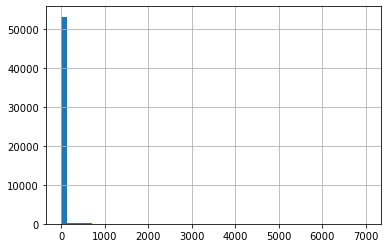

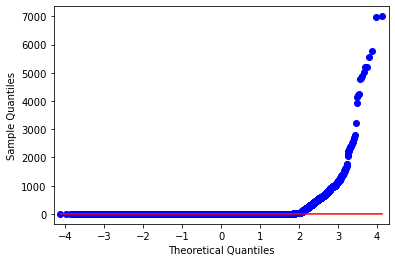

The median of collection_recovery_fee is: 0.0
The mean of collection_recovery_fee is: 10.778858311022827
The skew of collection_recovery_fee is: 27.807754340152847
count    54151.000000
mean        10.778858
std        119.907507
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       7002.190000
Name: collection_recovery_fee, dtype: float64
collection_recovery_fee 25th percentile: 0.0
collection_recovery_fee 75th percentile: 0.0
collection_recovery_fee IQR: 0.0
collection_recovery_fee number of outliers: 3391
collection_recovery_fee percentage of outliers: 6.2621188897711955
collection_recovery_fee Outliers:              id  member_id  loan_amount  funded_amount  funded_amount_inv  \
117    38644867   41428644         7000         7000.0             7000.0   
314    38615516   41399301        11200        11200.0            11200.0   
634    38575663   41359459        13050        12000.0            13050.0   
967    38534642   41318387       

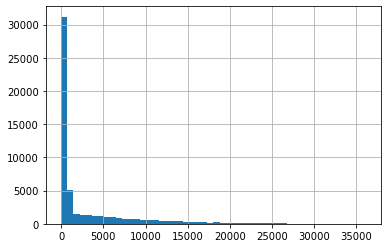

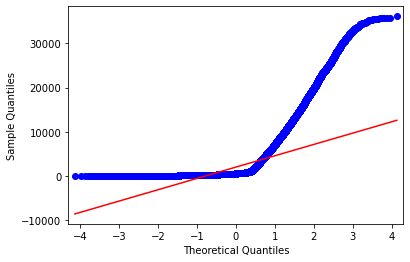

The median of last_payment_amount is: 563.55
The mean of last_payment_amount is: 3135.1190035271543
The skew of last_payment_amount is: 2.4972203995928135
count    54151.000000
mean      3135.119004
std       5326.386609
min          0.000000
25%        290.520000
50%        563.550000
75%       3749.495000
max      36115.200000
Name: last_payment_amount, dtype: float64
last_payment_amount 25th percentile: 290.52
last_payment_amount 75th percentile: 3749.495
last_payment_amount IQR: 3458.975
last_payment_amount number of outliers: 6693
last_payment_amount percentage of outliers: 12.359882550645418
last_payment_amount Outliers:              id  member_id  loan_amount  funded_amount  funded_amount_inv  \
2      38656154   41439961        16000        16000.0            16000.0   
3      38656128   41439934        15000        15000.0            15000.0   
25     38655682   41439481        15050        12000.0            15050.0   
38     38655401   41439196        25000        25000.0   

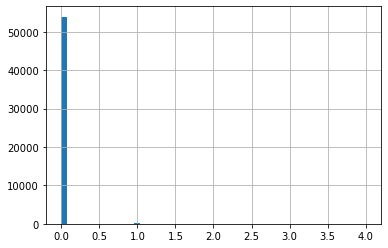

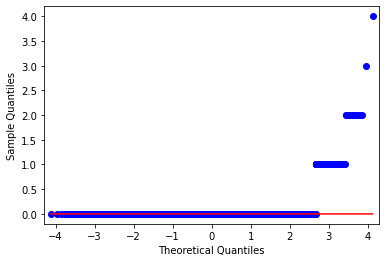

The median of collections_12_mths_ex_med is: 0.0
The mean of collections_12_mths_ex_med is: 0.004191981680855386
The skew of collections_12_mths_ex_med is: 20.307695011511576
count    54151.000000
mean         0.004192
std          0.070880
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: collections_12_mths_ex_med, dtype: float64
collections_12_mths_ex_med 25th percentile: 0.0
collections_12_mths_ex_med 75th percentile: 0.0
collections_12_mths_ex_med IQR: 0.0
collections_12_mths_ex_med number of outliers: 208
collections_12_mths_ex_med percentage of outliers: 0.3841110967479825
collections_12_mths_ex_med Outliers:              id  member_id  loan_amount  funded_amount  funded_amount_inv  \
32     38655517   41439313        12000        12000.0            12000.0   
37     38655413   41439208        35000        35000.0            35000.0   
42     38655130   41438916        20000        20000.0            20000.0   
89

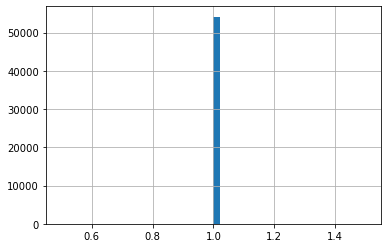

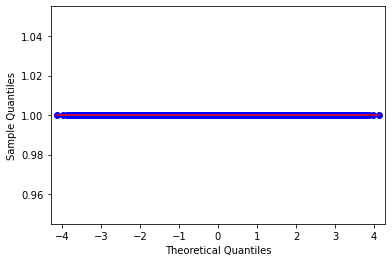

The median of policy_code is: 1.0
The mean of policy_code is: 1.0
The skew of policy_code is: 0
count    54151.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: policy_code, dtype: float64
policy_code 25th percentile: 1.0
policy_code 75th percentile: 1.0
policy_code IQR: 0.0
policy_code number of outliers: 0
policy_code percentage of outliers: 0.0
policy_code Outliers: Empty DataFrame
Columns: [id, member_id, loan_amount, funded_amount, funded_amount_inv, term, int_rate, instalment, grade, sub_grade, employment_length, home_ownership, annual_inc, verification_status, issue_date, loan_status, payment_plan, purpose, dti, delinq_2yrs, earliest_credit_line, inq_last_6mths, open_accounts, total_accounts, out_prncp, out_prncp_inv, total_payment, total_payment_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_payment_date, last_payment_amount, last_credit_pull_date, co

In [35]:
# Will visualise the columns and quantitively identify any outliers which potentially need to be removed 

# this function will generate the distribution of the relevant columns 

def dataframe_visualisation(dataframe, *args):
    columns_to_visualise = args
    for columns in columns_to_visualise:
        visualise_column = Plotter(dataframe, columns)
        visualise_column.data_distribution()
        visualise_column.identify_outliers()

dataframe_visualisation(payments_df_3, 'loan_amount', 'funded_amount', 'funded_amount_inv', 'term', 'int_rate', 'instalment', 'employment_length', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_accounts', 'total_accounts', 'out_prncp', 'out_prncp_inv', 'total_payment', 'total_payment_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_payment_amount', 'collections_12_mths_ex_med', 'policy_code')       

Now need to decide which outlier data to remove. 

Don't want to remove too much data and I only want to remove data which makes sense to remove.

Going to keep the outliers where most of the column fall into a small range of values as there maybe a reason why a small subset of values are different. I don't want to remove these and not gain potential insights into the data.

## columns to remove outliers from: 
- int_rate
- instalment
- annual_inc
- dti
- open_accounts
- total_accounts
- total_payment
- total_payment_inv
- total_rec_prncp
- total_rec_int


In [36]:
# copying the dataframe before removing the outliers in case something goes wrong!
payments_df_4 = payments_df_3.copy()

In [37]:
#function to remove all the outliers desired at once

def outlier_bulk_removal(dataframe, *args):
    columns_to_amend = args
    for columns in columns_to_amend:
        amend_column = DataFrameTransform(dataframe, columns)
        amend_column.remove_outliers()
        

outlier_bulk_removal(payments_df_4, 'int_rate', 'instalment', 'annual_inc', 'dti', 'open_accounts', 'open_accounts', 'total_accounts', 'total_payment', 'total_payment_inv', 'total_rec_prncp', 'total_rec_int')
    

Statistic=663.683, p=0.000


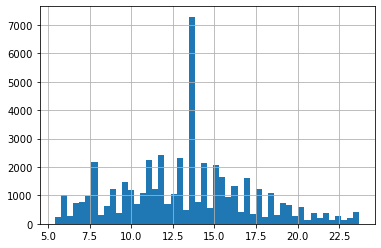

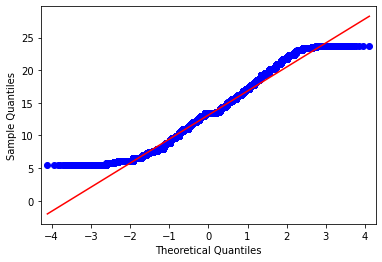

The median of int_rate is: 13.507328482327546
The mean of int_rate is: 13.27875488722867
The skew of int_rate is: 0.2504848747062941
count    50061.000000
mean        13.278755
std          3.907921
min          5.420000
25%         10.640000
50%         13.507328
75%         15.610000
max         23.700000
Name: int_rate, dtype: float64
int_rate 25th percentile: 10.64
int_rate 75th percentile: 15.61
int_rate IQR: 4.969999999999999
int_rate number of outliers: 574
int_rate percentage of outliers: 1.1466011466011465
int_rate Outliers:              id  member_id  loan_amount  funded_amount  funded_amount_inv  \
4249   10178156   12029818         3600         3600.0             3600.0   
4266   10177387   12029201         4125         4125.0             4125.0   
4283   10176714   12028737        30000        30000.0            30000.0   
4362   10168467   12020137         9000         9000.0             9000.0   
4421   10165655   12017753        30000        30000.0            29850.0  

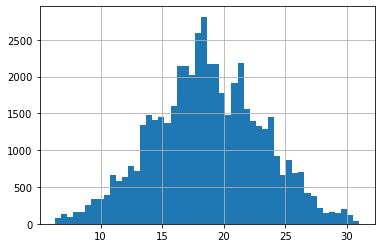

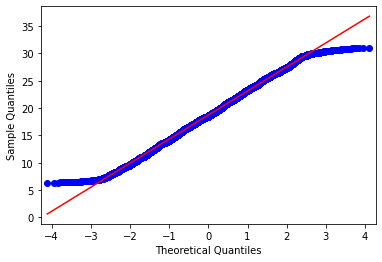

The median of instalment is: 18.527246202372858
The mean of instalment is: 18.674957100084328
The skew of instalment is: -0.0031328494734479254
count    50061.000000
mean        18.674957
std          4.443187
min          6.289187
25%         15.743047
50%         18.527246
75%         21.680479
max         31.020226
Name: instalment, dtype: float64
instalment 25th percentile: 15.74304685945206
instalment 75th percentile: 21.68047936846139
instalment IQR: 5.937432509009332
instalment number of outliers: 140
instalment percentage of outliers: 0.2796588162441821
instalment Outliers:              id  member_id  loan_amount  funded_amount  funded_amount_inv  \
181    38634902   41418676        35000        35000.0            35000.0   
1369   38465506   41259292        35000        35000.0            35000.0   
2052   38321923   41105674        35000        35000.0            35000.0   
4544   10155303   12007424         1000         1000.0             1000.0   
5468   10075017   11927142

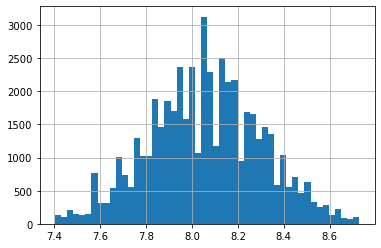

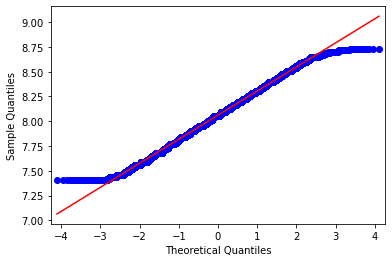

The median of annual_inc is: 8.047849181120334
The mean of annual_inc is: 8.05854303080257
The skew of annual_inc is: -0.009891700604203739
count    50061.000000
mean         8.058543
std          0.245247
min          7.402081
25%          7.898124
50%          8.047849
75%          8.225693
max          8.729146
Name: annual_inc, dtype: float64
annual_inc 25th percentile: 7.898124224523094
annual_inc 75th percentile: 8.225693314974947
annual_inc IQR: 0.32756909045185356
annual_inc number of outliers: 138
annual_inc percentage of outliers: 0.27566369029783666
annual_inc Outliers:              id  member_id  loan_amount  funded_amount  funded_amount_inv  \
388    38605883   41389670        24000        24000.0           24000.00   
930    38535548   41319338         4275         4275.0            4275.00   
1050   38514306   41308033         4000         4000.0            4000.00   
1189   38494232   41287947         5000         5000.0            5000.00   
2211   38282481   41066255 

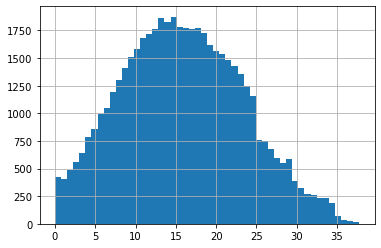

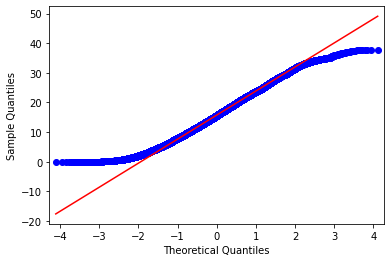

The median of dti is: 15.58
The mean of dti is: 15.845186272747343
The skew of dti is: 0.1747635421618061
count    50061.000000
mean        15.845186
std          7.536526
min          0.000000
25%         10.260000
50%         15.580000
75%         21.210000
max         37.760000
Name: dti, dtype: float64
dti 25th percentile: 10.26
dti 75th percentile: 21.21
dti IQR: 10.950000000000001
dti number of outliers: 5
dti percentage of outliers: 0.009987814865863646
dti Outliers:             id  member_id  loan_amount  funded_amount  funded_amount_inv  \
410   38604985   41388743        23700        23700.0            23700.0   
1871  38372507   41156295         9450         9450.0             9450.0   
2696  38171728   40955471        14800        14800.0            14800.0   
2774  38151638   40935379        14475        14475.0            14475.0   
3156  37887527   40650256        30000        30000.0            30000.0   

      term   int_rate  instalment grade sub_grade  ...  total_re

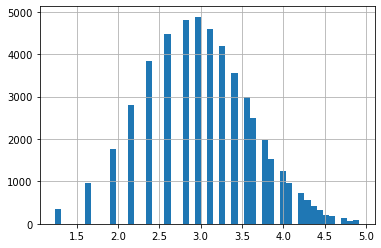

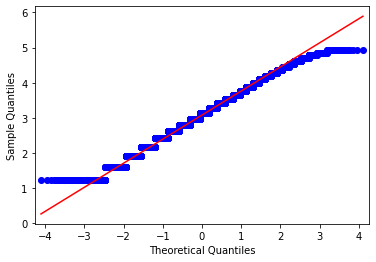

The median of open_accounts is: 3.1276243824521655
The mean of open_accounts is: 3.0832620331844467
The skew of open_accounts is: -0.07644143420493595
count    50061.000000
mean         3.083262
std          0.658002
min          1.237501
25%          2.614983
50%          3.127624
75%          3.539602
max          4.919905
Name: open_accounts, dtype: float64
open_accounts 25th percentile: 2.614983319217588
open_accounts 75th percentile: 3.539602173267412
open_accounts IQR: 0.9246188540498239
open_accounts number of outliers: 0
open_accounts percentage of outliers: 0.0
open_accounts Outliers: Empty DataFrame
Columns: [id, member_id, loan_amount, funded_amount, funded_amount_inv, term, int_rate, instalment, grade, sub_grade, employment_length, home_ownership, annual_inc, verification_status, issue_date, loan_status, payment_plan, purpose, dti, delinq_2yrs, earliest_credit_line, inq_last_6mths, open_accounts, total_accounts, out_prncp, out_prncp_inv, total_payment, total_payment_inv, to

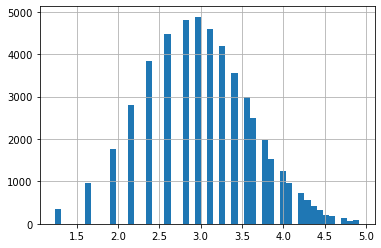

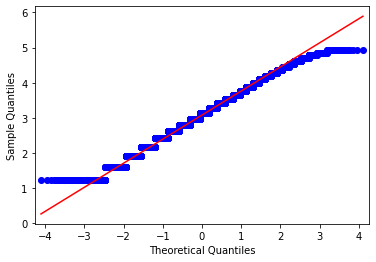

The median of open_accounts is: 3.1276243824521655
The mean of open_accounts is: 3.0832620331844467
The skew of open_accounts is: -0.07644143420493595
count    50061.000000
mean         3.083262
std          0.658002
min          1.237501
25%          2.614983
50%          3.127624
75%          3.539602
max          4.919905
Name: open_accounts, dtype: float64
open_accounts 25th percentile: 2.614983319217588
open_accounts 75th percentile: 3.539602173267412
open_accounts IQR: 0.9246188540498239
open_accounts number of outliers: 0
open_accounts percentage of outliers: 0.0
open_accounts Outliers: Empty DataFrame
Columns: [id, member_id, loan_amount, funded_amount, funded_amount_inv, term, int_rate, instalment, grade, sub_grade, employment_length, home_ownership, annual_inc, verification_status, issue_date, loan_status, payment_plan, purpose, dti, delinq_2yrs, earliest_credit_line, inq_last_6mths, open_accounts, total_accounts, out_prncp, out_prncp_inv, total_payment, total_payment_inv, to

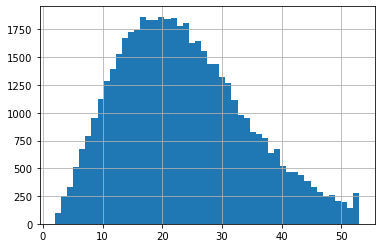

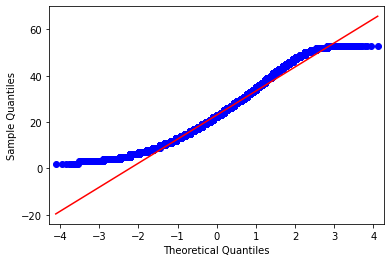

The median of total_accounts is: 22.0
The mean of total_accounts is: 23.54875052436028
The skew of total_accounts is: 0.473068639562518
count    50061.000000
mean        23.548751
std         10.459176
min          2.000000
25%         16.000000
50%         22.000000
75%         30.000000
max         53.000000
Name: total_accounts, dtype: float64
total_accounts 25th percentile: 16.0
total_accounts 75th percentile: 30.0
total_accounts IQR: 14.0
total_accounts number of outliers: 273
total_accounts percentage of outliers: 0.5453346916761551
total_accounts Outliers:              id  member_id  loan_amount  funded_amount  funded_amount_inv  \
177    38635085   41418864        12725        12725.0       12725.000000   
306    38615810   41399604        10000        10000.0       10000.000000   
309    38615739   41399531        35000        35000.0       34700.000000   
470    38595593   41379366        18600        12000.0       18600.000000   
603    38584552   41368296        16000      

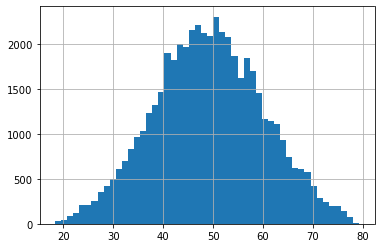

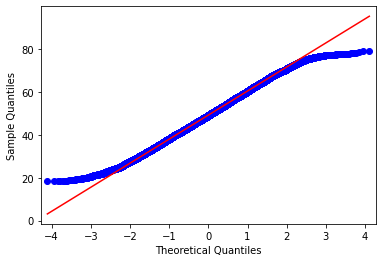

The median of total_payment is: 49.080234989428234
The mean of total_payment is: 49.159947466780054
The skew of total_payment is: 0.010175024544949264
count    50061.000000
mean        49.159947
std         10.876301
min         18.295825
25%         41.632647
50%         49.080235
75%         56.772840
max         79.310713
Name: total_payment, dtype: float64
total_payment 25th percentile: 41.632646884375895
total_payment 75th percentile: 56.77284017428962
total_payment IQR: 15.140193289913725
total_payment number of outliers: 15
total_payment percentage of outliers: 0.029963444597590937
total_payment Outliers:              id  member_id  loan_amount  funded_amount  funded_amount_inv  \
20     38655850   41439654         1500        12000.0            1500.00   
209    38626372   41410175         3000         3000.0            3000.00   
1435   38455783   41249594         1400         1400.0            1400.00   
3079   37938556   40701308         1400         1400.0            1400.0

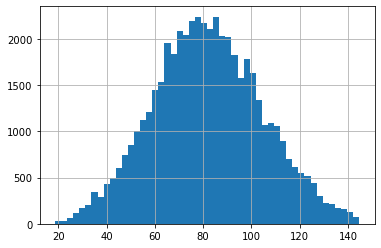

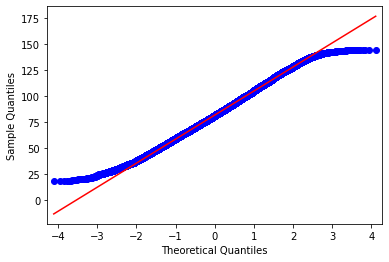

The median of total_payment_inv is: 81.38512854279347
The mean of total_payment_inv is: 82.01564675729213
The skew of total_payment_inv is: 0.09893400998697618
count    50061.000000
mean        82.015647
std         22.540293
min         18.632536
25%         66.313136
50%         81.385129
75%         97.424971
max        144.698279
Name: total_payment_inv, dtype: float64
total_payment_inv 25th percentile: 66.31313595879362
total_payment_inv 75th percentile: 97.42497118184752
total_payment_inv IQR: 31.1118352230539
total_payment_inv number of outliers: 23
total_payment_inv percentage of outliers: 0.04594394838297277
total_payment_inv Outliers:             id  member_id  loan_amount  funded_amount  funded_amount_inv  \
9880   9076266   10888294        35000        35000.0       34975.000000   
15249  8595519   10347612        35000        35000.0       35000.000000   
23811  7356180    9018298        35000        35000.0       35000.000000   
23878  7346129    9008259        35000     

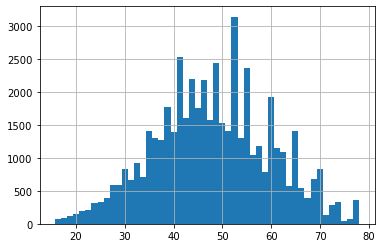

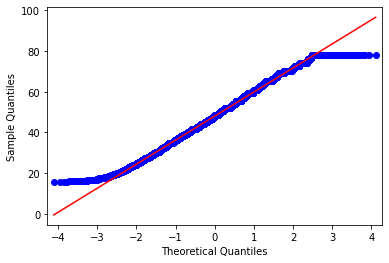

The median of total_rec_prncp is: 48.03977114904973
The mean of total_rec_prncp is: 48.07231182465722
The skew of total_rec_prncp is: 0.026327093697490114
count    50061.000000
mean        48.072312
std         11.910426
min         15.729734
25%         39.978979
50%         48.039771
75%         55.939227
max         77.993025
Name: total_rec_prncp, dtype: float64
total_rec_prncp 25th percentile: 39.978978861752594
total_rec_prncp 75th percentile: 55.93922662660329
total_rec_prncp IQR: 15.960247764850699
total_rec_prncp number of outliers: 15
total_rec_prncp percentage of outliers: 0.029963444597590937
total_rec_prncp Outliers:              id  member_id  loan_amount  funded_amount  funded_amount_inv  \
117    38644867   41428644         7000         7000.0             7000.0   
8651    9199723   11061631        15000        15000.0            15000.0   
8832    9194795   11056938         6000         6000.0             6000.0   
13235   8814577   10586728        35000        35000.0

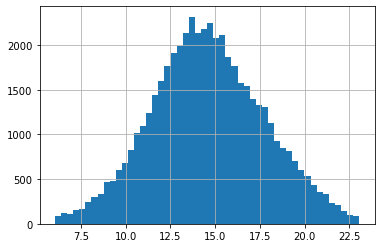

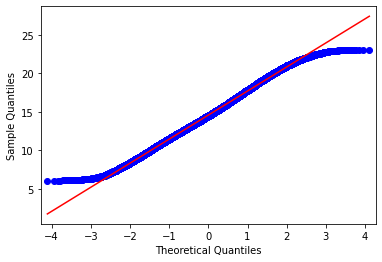

The median of total_rec_int is: 14.495693318101686
The mean of total_rec_int is: 14.5897222227473
The skew of total_rec_int is: 0.06435709113484828
count    50061.000000
mean        14.589722
std          3.119354
min          6.051754
25%         12.471794
50%         14.495693
75%         16.692944
max         23.051323
Name: total_rec_int, dtype: float64
total_rec_int 25th percentile: 12.471793572041612
total_rec_int 75th percentile: 16.692943703912213
total_rec_int IQR: 4.221150131870601
total_rec_int number of outliers: 23
total_rec_int percentage of outliers: 0.04594394838297277
total_rec_int Outliers:              id  member_id  loan_amount  funded_amount  funded_amount_inv  \
1788   38414490   41198267         8000        12000.0             8000.0   
3111   37917473   40680207         4300         4300.0             4300.0   
11962   8965374   10757477         1925         1925.0             1925.0   
12774   8875957   10668032         5000         5000.0             5000.0   

In [38]:
# visualisation of the columns after outlier removal
dataframe_visualisation(payments_df_4, 'int_rate', 'instalment', 'annual_inc', 'dti', 'open_accounts', 'open_accounts', 'total_accounts', 'total_payment', 'total_payment_inv', 'total_rec_prncp', 'total_rec_int')

After removing the outliers the data will be less biased by these values. 

Even after removing outliers the outlier metric is still picking up outliers as quartiles will shift upon removal of data meaning new data counts as an outlier.

But I do not want to reiterate this process as too much data will be lost.

In [39]:
# amount and percentage of data removed due to being outlier 
print(len(payments_df_3) - len(payments_df_4))
print(((len(payments_df_3) - len(payments_df_4))/len(payments_df_3))*100)

4090
7.552953777400233


Since outliers were detected for inedpendent columns and removed, even if a small number were removed for each column the removal effect compounds over the data set as a whole, hence ~ 7.6% of the data was removed  

Next I will need to measure the collinearity of the columns and then remove highly correlated columns.

I will visualise the data as a whole using a correlation matrix and then use statistics to decide if the visually identified correlated columns can be removed. 

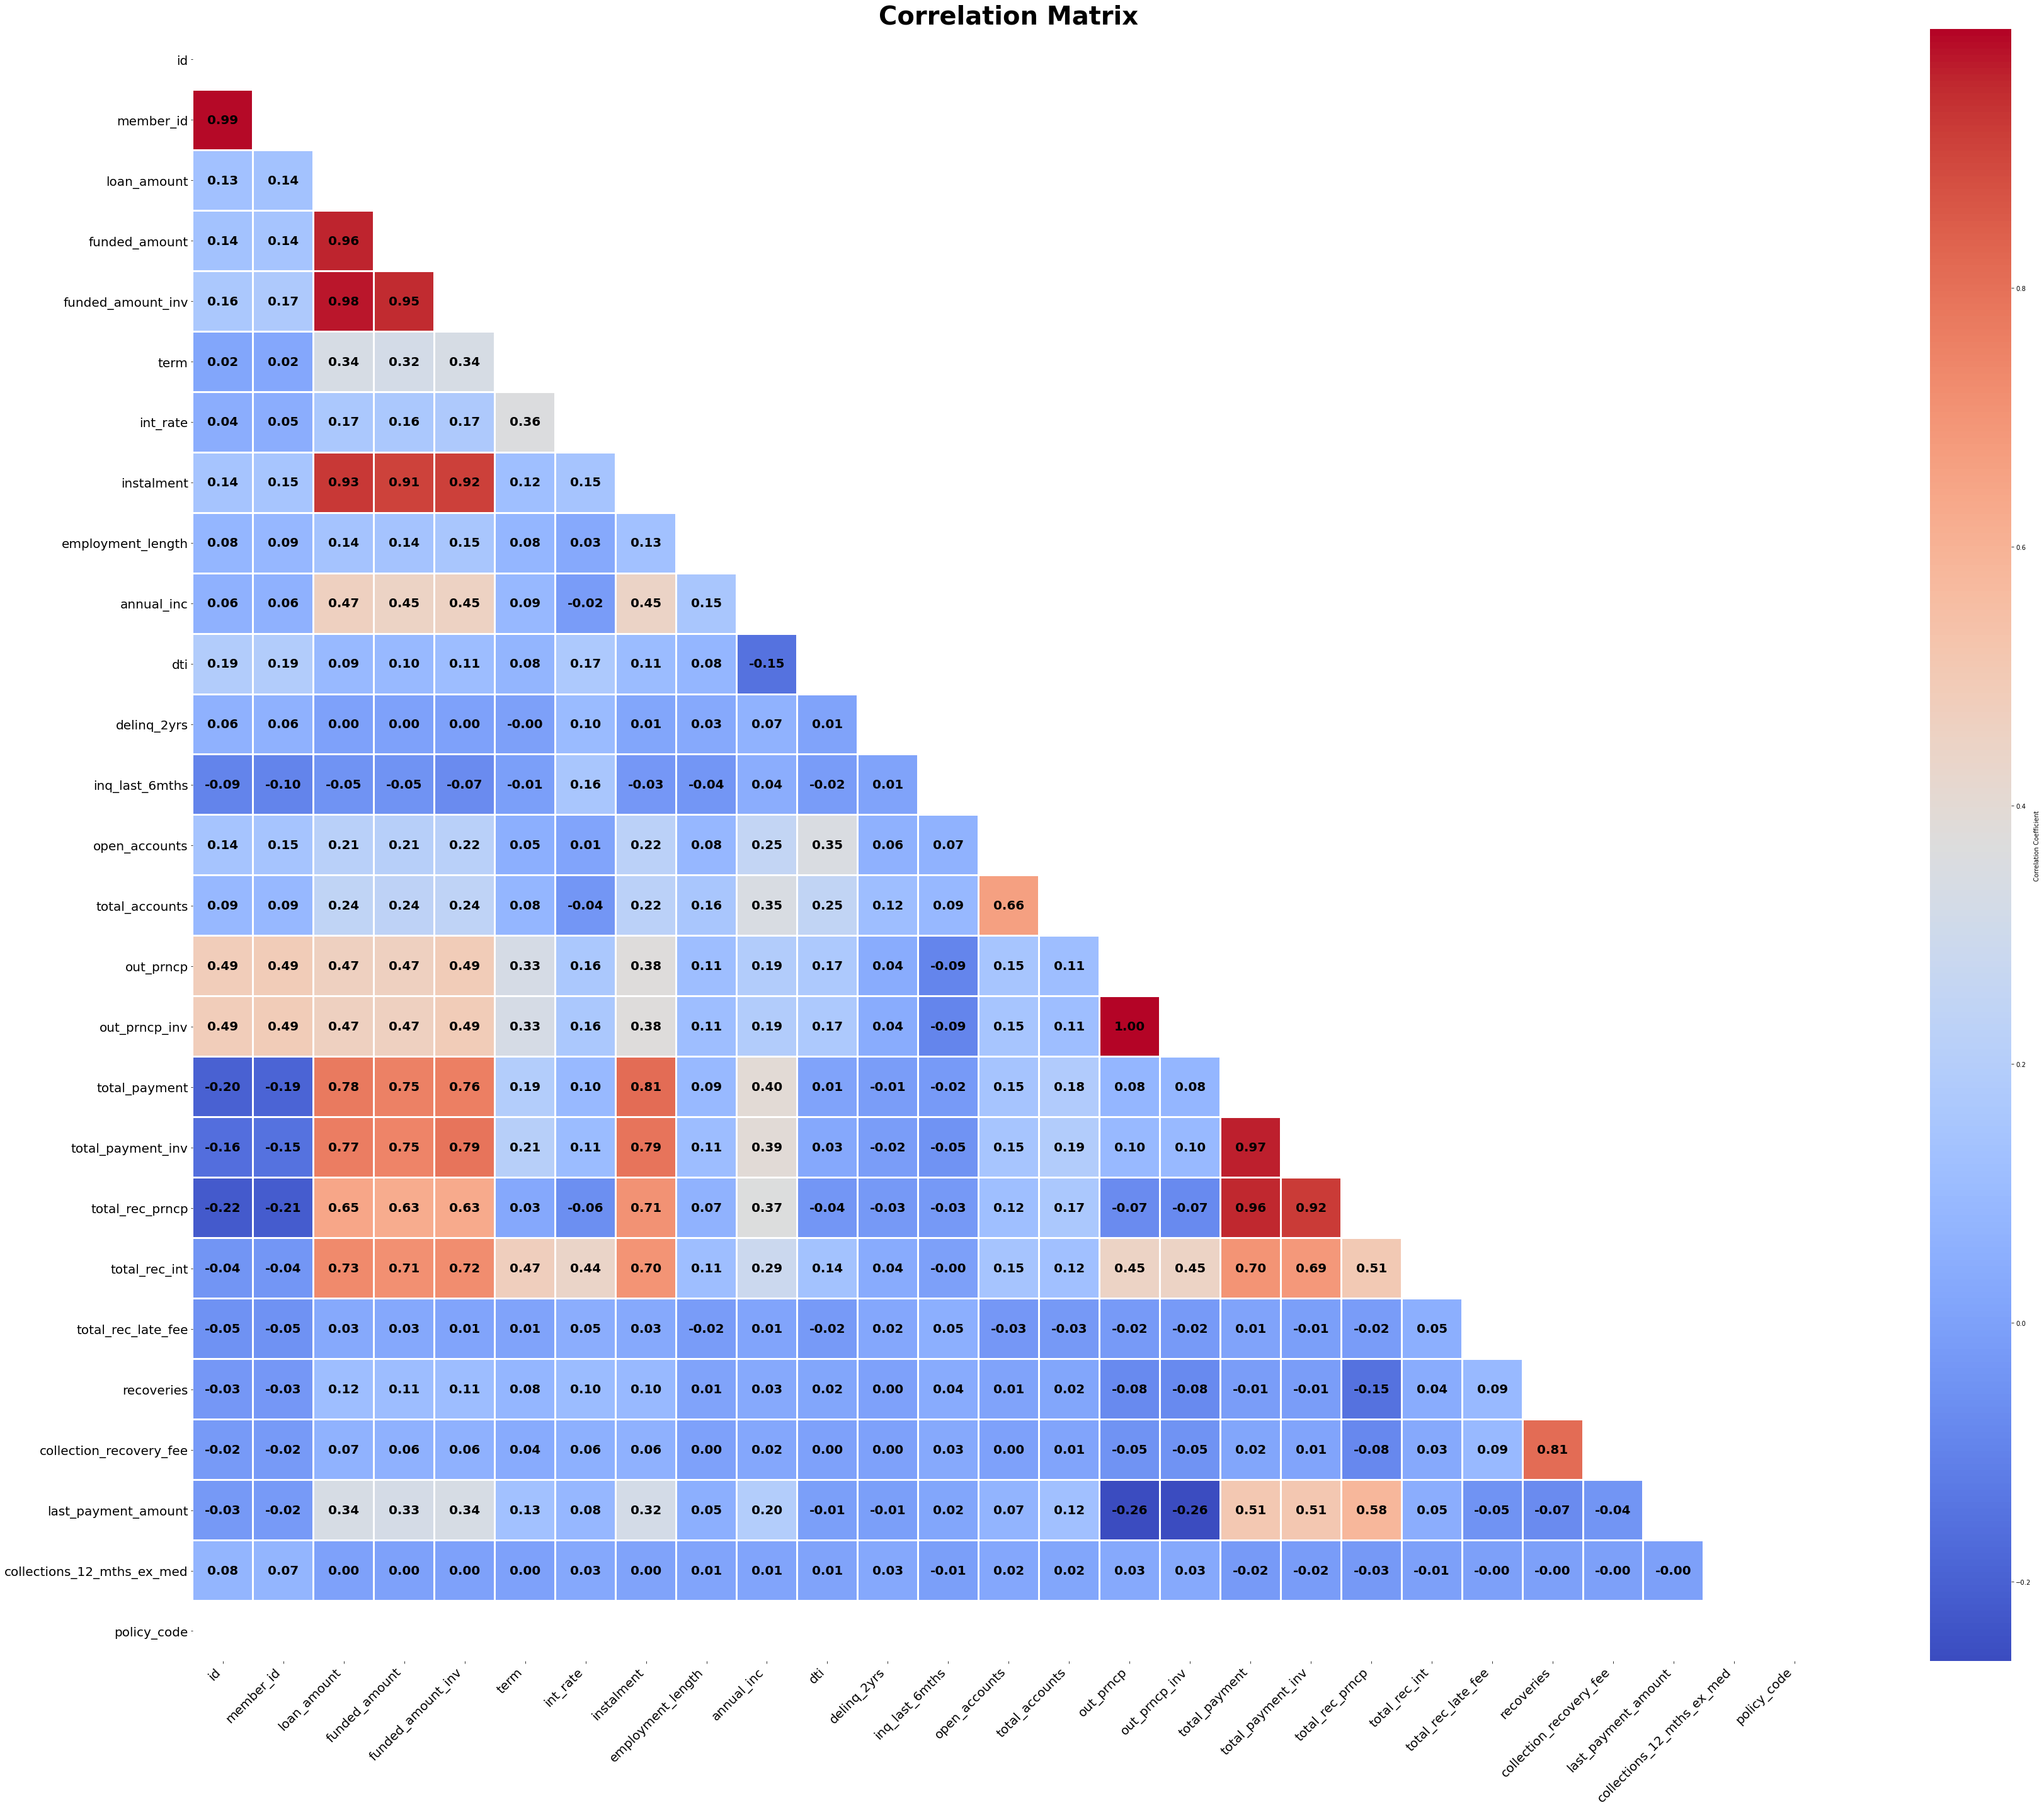

In [40]:
# Visualise collinearity using a correlation matrix

dataframe_correlation_matrix = Plotter(payments_df_4, 'term')
dataframe_correlation_matrix.correlation_matrix()

## Highly Correlated Columns:
- member_id: id
- loan_amount:instalment, funded_amount_inv, funded_amount
- funded_amount: instalment, funded_amount_inv
- funded_amount_inv: instalment
- out_prncp: out_prncp_inv
- total_payment: total_rec_prncp, total_payment_inv
- total_payment_inv: total_rec_prncp

In [41]:
# Linear regression models and VIF are used to see if these values are colinear - threshold of P > 0.9
# id and member_id will be left as we want to keep the unique id of the loan and of the member who took out the loan

model_1 = smf.ols("loan_amount ~ instalment + funded_amount + funded_amount_inv", payments_df_4).fit()
model_2 = smf.ols("instalment ~ loan_amount + funded_amount + funded_amount_inv", payments_df_4).fit()
model_3 = smf.ols("funded_amount ~ loan_amount + instalment + funded_amount_inv", payments_df_4).fit()
model_4 = smf.ols("funded_amount_inv ~ loan_amount + instalment + funded_amount", payments_df_4).fit()

def VIF(model):
    model_r2 = model.rsquared
    model_VIF = 1/(1-model_r2)
    print(f'R^2 for model: {model_r2}')
    print(f'VIF for model: {model_VIF}')

model_1.summary() 
VIF(model_1)
VIF(model_2)
VIF(model_3)
VIF(model_4)

R^2 for model: 0.9677007050299192
VIF for model: 30.960428112326046
R^2 for model: 0.8649747229425501
VIF for model: 7.406020722879351
R^2 for model: 0.9347164938723878
VIF for model: 15.31780474604505
R^2 for model: 0.9543414232025739
VIF for model: 21.901690112609295


In [42]:
model_5 = smf.ols("out_prncp ~ out_prncp_inv", payments_df_4).fit()
VIF(model_5)

R^2 for model: 0.9999937536348137
VIF for model: 160093.1053776952


In [43]:
model_6 = smf.ols("total_payment ~ total_rec_prncp + total_payment_inv", payments_df_4).fit()
model_7 = smf.ols("total_rec_prncp ~ total_payment + total_payment_inv", payments_df_4).fit()
model_8 = smf.ols("total_payment_inv ~ total_payment + total_rec_prncp", payments_df_4).fit()
VIF(model_6)
VIF(model_7)
VIF(model_8)

R^2 for model: 0.9647072088844142
VIF for model: 28.3343982833476
R^2 for model: 0.9156764014800026
VIF for model: 11.859076433542498
R^2 for model: 0.9385825339820564
VIF for model: 16.2820133235038


## Columns To Drop:
 - instalment
 - funded_amount 
 - funded_amount_inv
 - total_rec_prncp 
 - total_payment_inv
 - out_prncp_inv

In [44]:
payments_df_5 = payments_df_4.drop(['instalment', 'funded_amount', 'funded_amount_inv', 'total_rec_prncp', 'total_payment_inv', 'out_prncp_inv'], axis = 1)

# a quick summary of the remaining data after cleaning. 
payments_df_5.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50061 entries, 0 to 54225
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          50061 non-null  int64         
 1   member_id                   50061 non-null  int64         
 2   loan_amount                 50061 non-null  int64         
 3   term                        50061 non-null  float64       
 4   int_rate                    50061 non-null  float64       
 5   grade                       50061 non-null  object        
 6   sub_grade                   50061 non-null  object        
 7   employment_length           50061 non-null  float64       
 8   home_ownership              50061 non-null  object        
 9   annual_inc                  50061 non-null  float64       
 10  verification_status         50061 non-null  object        
 11  issue_date                  50061 non-null  datetime64

## Seeing what percentage of the expected amount to be paid was recovered

payments_df_2, the untransformed dataframe was used so calculations will work. However, this does have the limitation of certain columns no longer being normally distributed. 

In [45]:
def percentage_of_loan_recovered():
    df = payments_df_2 
    n = df['term']
    monthly_payment = df['instalment']
    # the final amount that is expected to be paid by the customer,
    # the amount they pay in one month * the number of months they are paying back the loan for.
    final_payment_amount = monthly_payment*n
    
    # the amount paid towards the loan + the interest 
    current_amount_recovered = df['total_payment'] + df['total_rec_int']
    
    percentage_recovered = (current_amount_recovered/final_payment_amount)*100
    
    # adding these columns to the dataframe so they can be used for future analysis
    df['final_payment_amount'] = final_payment_amount
    df['current_amount_recovered'] = current_amount_recovered
    df['percentage_recovered'] = percentage_recovered
    
    

percentage_of_loan_recovered()

 

In [46]:
# mean, median and standard deviation of the percentage recovered

percentage_recovered_summary = DataFrameInfo(payments_df_2,'percentage_recovered')
percentage_recovered_summary.mean_of_column()
percentage_recovered_summary.median_of_column()
percentage_recovered_summary.std_of_column()


mean of percentage_recovered: 89.93986576006576
median of percentage_recovered: 94.83000467843185
 Standard Deviation of percentage_recovered: 27.98164169300553


Calculate how much will be paid in 6 months time with interest.
Need to add on amount paid in 6 months - instalment*6 but do not want to add this to loans which have already been paid fully or loans that will be paid fully before 6 months.

In [47]:

def six_months_payment():
    df = payments_df_2
    six_months_amount_list = []
    for index, row in df.iterrows():
        # seeing if they have paid to equal to or more than the full amount expected.
        # in this case there will be no additional payment after 6 months.
        if row['current_amount_recovered'] >= row['final_payment_amount']:
            six_months_amount = row['current_amount_recovered']
        # if the total amount expected amount to be paid after 6 further months is more than or eqaul to
        # the final expected payment total then that final amount will be the total paid after 6 more months
        elif row['current_amount_recovered'] + 6*row['instalment'] >= row['final_payment_amount']:
            six_months_amount = row['final_payment_amount']
        # if the other two scenarios don't apply then can just add 6 more monthly payments to the amount recovered already.
        else:
            six_months_amount = row['current_amount_recovered'] + 6*row['instalment'] 
    
        six_months_amount_list.append(six_months_amount)
    
    # total that will be paid after 6 further months.
    df['six_months_amount'] = six_months_amount_list
    
    # amount that will actually paid in just that 6 month period 
    df['six_months_amount_left'] = df['six_months_amount'] - df['current_amount_recovered']

        
six_months_payment()



## graph of total amount to be paid after a further 6 months
 y axis total amount to be paid
 x axis time 1 - 6 months
 
 I will need the total to be paid in each month seperately as some loans will have been fully paid before 6 months is up. I would not expect the graph to be linear but would begin to curve/flatten as more of the loans are paid and therefore the total additional payments for the subsequent months would decrease.   
 

In [48]:
# based off the previous function the amount paid in total for the different months can be done as a class,
# with the previous function being a method of the class.

class AmountPaidInMonth:
    def __init__(self, dataframe, num_months):
        self.dataframe = dataframe
        self.num_months = num_months
    
    def monthly_payment(self):
        df = self.dataframe
        monthly_amount_list = []
        for index, row in df.iterrows():
            if row['current_amount_recovered'] >= row['final_payment_amount']:
                 months_amount = row['current_amount_recovered']
            elif row['current_amount_recovered'] + self.num_months*row['instalment'] >= row['final_payment_amount']:
                 months_amount = row['final_payment_amount']
            else:
                 months_amount = row['current_amount_recovered'] + self.num_months*row['instalment'] 
    
            monthly_amount_list.append(months_amount)
    
        df[f'{self.num_months}_months_amount'] = monthly_amount_list
        df[f'{self.num_months}_months_amount_left'] = df[f'{self.num_months}_months_amount'] - df['current_amount_recovered']
    
    
    


In [49]:
# apply the method for each month 

one_month = AmountPaidInMonth(payments_df_2, 1)
one_month.monthly_payment()
two_months = AmountPaidInMonth(payments_df_2,2)
two_months.monthly_payment()
three_months = AmountPaidInMonth(payments_df_2, 3)
three_months.monthly_payment()
four_months = AmountPaidInMonth(payments_df_2, 4)
four_months.monthly_payment()
five_months = AmountPaidInMonth(payments_df_2, 5)
five_months.monthly_payment()
six_months = AmountPaidInMonth(payments_df_2, 6)
six_months.monthly_payment()

In [50]:
# for the graph we need the sums of the newly generated columns
# the totals show the amount that will be paid in each month of that 6 month period,
# but will cumulative i.e. three month total is amount paid in month 1 + month 2 + month 3 
one_month_total = payments_df_2['1_months_amount_left'].sum()
two_month_total = payments_df_2['2_months_amount_left'].sum()
three_month_total = payments_df_2['3_months_amount_left'].sum()
four_month_total = payments_df_2['4_months_amount_left'].sum()
five_month_total = payments_df_2['5_months_amount_left'].sum()
six_month_total = payments_df_2['6_months_amount_left'].sum()

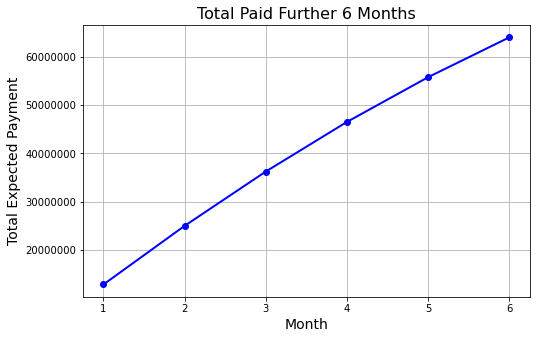

In [51]:
# Plotting the graph
total_list = [one_month_total, two_month_total, three_month_total, four_month_total, five_month_total, six_month_total]
month_list = [1,2,3,4,5,6]
plt.figure(figsize=(8, 5))
plt.plot(month_list, total_list, marker='o', color='b', linestyle='-', linewidth=2, markersize=6)
plt.title("Total Paid Further 6 Months", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Total Expected Payment", fontsize=14)
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.grid(True)
plt.show()

Loans marked as charged off represent a loss to the company.

Need to see what percentage of loans have been charged off and how much was paid back towards these loans.

In [52]:
# filtering the database on the condition of loans being charged off
loss_loans = payments_df_2.loc[payments_df_2['loan_status'] == 'Charged Off']

# the number in the filtered database can be compare to the number in the enitre database to determine the percentage
loss_loan_percentage = len(loss_loans)/len(payments_df_2)*100
print(f' This percentage of lones were loses: {loss_loan_percentage:.4g}%')

 This percentage of lones were loses: 10.16%


In [53]:
# the total amount paid off towards these lones + interest

total_payment_of_loss_loans = loss_loans['total_payment'].sum() + loss_loans['total_rec_int'].sum()
print(total_payment_of_loss_loans)

49856893.09081949


In [54]:
# projected loss, the amount loaned out minus the amount paid back before being charged off. 
total_loan_amount_of_loss_loans = loss_loans['loan_amount'].sum()
total_lost = total_loan_amount_of_loss_loans - total_payment_of_loss_loans 
print(total_lost)

25843381.909180507


In [55]:
# revenue was lost from the further money that would have been paid back due to interest
# need to see how much would have been paid back if a full term of payments on these loans was made. 

full_term_loss_loans = loss_loans['final_payment_amount'].sum()
revenue_lost = full_term_loss_loans - total_payment_of_loss_loans 
print(revenue_lost)


51340326.349180505


## Graph to show what total revenue would have been generated if a full term of payments would have been in the loans that were charged off. 
- need the approximate number of payments made towards each loan
- can then calculate approximately how many further payments would have been needed to pay the full expected amount 
- need the revenue lost from each loan
- can then calculate the total amount lost for each month.
- can then plot of graph of these totals for month 1, 60. 60 being the longest term length 

In [56]:

# estimate of number of payments made and number of payments left
# based off how much they have paid in total and how much they pay back in one month 
# some people may have paid back more than the total expected,
# they might have incurred additional fees which were the ones that were charged off
number_of_payments_made = (loss_loans['total_payment'] + loss_loans['total_rec_int'])/loss_loans['instalment']
number_of_payments_left =  loss_loans['term'] - number_of_payments_made
number_of_payments_left[number_of_payments_left < 0] = 0
    
# series showing the revenue lost in each lone.
revenue_lost_loan = loss_loans['final_payment_amount'] - (loss_loans['total_payment'] + loss_loans['total_rec_int'])
revenue_lost_loan[revenue_lost_loan < 0] = 0
loss_loans['revenue_lost_loan'] = revenue_lost_loan

#function to add the cumulative amount of revenue lost in each month for the charged off loans 

# list to store the cumulative totals for each month, which can be used as the y - axis in the graph 
cumulative_sums = []
def losses_each_month():
    df = loss_loans  
    # for loop to go through every month from one to the last month in the longest term 60 
    for month in range(1, 61):
        total_payment_for_month = 0
        # for loop to go through each row in the data frame 
        for index, row in df.iterrows():
            # only want to add the total lost for each loan for each month up to the point of the total revenue lost for that loan
            if (row['instalment'] * month) >= row['revenue_lost_loan']:
                total_payment_for_month += row['revenue_lost_loan']
            else:
                total_payment_for_month += (row['instalment'] * month)
        
        # when the cumulative amount lost for each month is calculated it is added to the list
        cumulative_sums.append(total_payment_for_month)
    return(cumulative_sums)
    
losses_each_month()

<ipython-input-56-1b56cd2f64ad>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loss_loans['revenue_lost_loan'] = revenue_lost_loan


[2112340.219999998,
 4209353.639999997,
 6288587.669108817,
 8351753.669108821,
 10395098.799108831,
 12415137.329108804,
 14412262.830983005,
 16377682.19105544,
 18298374.341055397,
 20168397.28105542,
 21982359.03105548,
 23734031.26105535,
 25424541.58105539,
 27045629.731055297,
 28609008.821055364,
 30112792.071055412,
 31556327.231055398,
 32946022.901055343,
 34281483.341055326,
 35562476.81105536,
 36784876.59105543,
 37947111.45105544,
 39046074.4210554,
 40091364.26105538,
 41085935.71105538,
 42022872.10105544,
 42895185.59105541,
 43704532.57105536,
 44450281.3410554,
 45134054.621055424,
 45753522.08105548,
 46321002.7810555,
 46843308.3310554,
 47329993.96105543,
 47781679.29105552,
 48203723.66105542,
 48599191.31105542,
 48967621.92105541,
 49310691.2710554,
 49629899.38105542,
 49928709.571055494,
 50206603.411055446,
 50457957.48105541,
 50686669.94105538,
 50896960.18105541,
 51085899.451055445,
 51257566.46105552,
 51411197.68105542,
 51543815.701055504,
 51654429.

In [57]:
# checking if the estimate for total revenue lost generated by this function is similar to the total revenue lost calculated previously.
# percentage difference between the two amounts
(cumulative_sums[-1] - revenue_lost)/(revenue_lost)*100

1.230847497106064

This percentage difference is small so can comfortably use the values from the iterative function as approximations for the graph. 

In [58]:
# making a list of months from 1 - 60 to use as the x axis in the graph 

month_list = []
for num in range(1, 61):
    month_list.append(num)


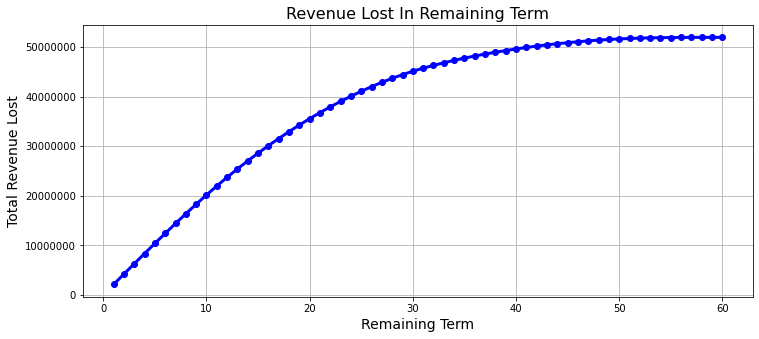

In [59]:
# Now have everything needed to plot the graph

plt.figure(figsize=(12, 5))
plt.plot( month_list,cumulative_sums, marker='o', color='b', linestyle='-', linewidth=3, markersize=6)
plt.title("Revenue Lost In Remaining Term", fontsize=16)
plt.xlabel("Remaining Term", fontsize=14)
plt.ylabel("Total Revenue Lost", fontsize=14)
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.grid(True)
plt.show()

Need to also find out which customers are currently behind on their loan payments as they represent a risk to the company.

In [60]:

# time diference between last payment date and issue date gives the amount of time loan the loan as been in place,
# if the payments had been on time

payments_df_2['time_difference'] = payments_df_2['last_payment_date'] - payments_df_2['issue_date']

# convert deltatime into days 
payments_df_2['total_days'] = payments_df_2['time_difference'].dt.days

# dividing this number by the approximate number of days in month 365/12,
# to get the total number of months payments had been made for
payments_df_2['total_months'] = round(payments_df_2['total_days']/30.42)

# can then work how would have been expected to be paid in that time 

payments_df_2['expected_payment'] = payments_df_2['instalment'] * payments_df_2['total_months']

# if that number is less than the total they have paid they are behind on payments
# don't want to include loans which have already been charged off 
# filter the data frame using these conditions 
behind_loans = payments_df_2.loc[(payments_df_2['expected_payment'] > payments_df_2['current_amount_recovered']) & (payments_df_2['loan_status'] != 'Charged Off')]
                               

In [61]:
print(f'Perecentage of loans where customers are behind on their payments: {(len(behind_loans)/len(payments_df_2))*100}%')

Perecentage of loans where customers are behind on their payments: 0.07940758250078483%


In [62]:
# number of customers behind on payments  
print(len(behind_loans))
# how much loss the company would incur if their status was changed to Charged Off.
potential_losses_charged_off = (behind_loans['loan_amount'] - behind_loans['current_amount_recovered']).sum()
print(potential_losses_charged_off)

43
-74461.64459919003


The company still has recovered more than they intially lent out on these loans. 

However, they are still losing out on the interest. 

So will also need to calculate the total revenue lost.

In [63]:
# revenue lost if these loans were charged off
revenue_lost_if_full_term = (behind_loans['final_payment_amount'] - behind_loans['current_amount_recovered']).sum()
print(revenue_lost_if_full_term)


35189.67540080999


In [64]:
# If customers that are late on payments converted to Charged Off, what percentage of total expected revenue do these customers and the customers who have already defaulted on their loan represent?

# total_expected_revenue
total_expected_revenue = payments_df_2['final_payment_amount'].sum()
late_payment_expected_revenue_lost = behind_loans['final_payment_amount'].sum() - behind_loans['current_amount_recovered'].sum()
charged_off_expected_revenue_lost = loss_loans['final_payment_amount'].sum() - loss_loans['current_amount_recovered'].sum()

percentage_of_expected_revenue_lost = ((late_payment_expected_revenue_lost + charged_off_expected_revenue_lost)/total_expected_revenue)*100

print(percentage_of_expected_revenue_lost)


5.544136440348897


## Indicators For Not Paying Back Loans:
- plot graphs for late payers, charged off loans, and whole data set
- see which look like they more likely to occur in the first two groups
- compare these two groups quantitively with the entire dataset 

In [65]:
# class used to compare the proportions of a value in the two subset data frames with the entire sample data frame

class StatsTests:
    def __init__(self, dataframe_1, dataframe_2, column, subset):
        self.dataframe_1 = dataframe_1
        self.dataframe_2 = dataframe_2
        self.column = column
        self.subset = subset
        self.sample_proportion = len(self.dataframe_2.loc[self.dataframe_2[self.column] == subset])/len(self.dataframe_2)
        self.populations_proportion= len(self.dataframe_1.loc[self.dataframe_1[self.column] == subset])/len(self.dataframe_1)

    def proportion_z_test(self):
        ps = self.sample_proportion 
        pp = self.populations_proportion
        n = len(self.dataframe_2)
    
        z = (ps - pp)/((pp*(1 - pp))/n)**0.5
        print(f'sample size: {n}')
        print(f' proportion in sample: {ps}')
        print(f' proportion in population: {pp}')
        print(f' z score: {z}')

In [66]:
# compare the number of each grade in each data set.
#  if a grade occurs more frequently in the behind payments subset or the charged off subset,
# that grade could be an indicator for people not paying back their loans

# will first compare visually using graphs in the plotter class
g_full_data_set = Plotter(payments_df_2, 'grade')
g_behind_data_set = Plotter(behind_loans, 'grade')
g_loss_data_set = Plotter(loss_loans, 'grade')


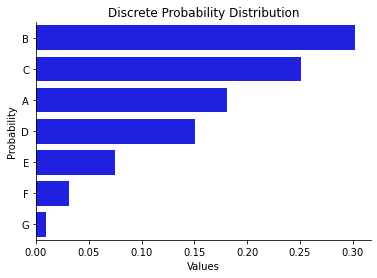

In [67]:
g_full_data_set.draw_dpd()

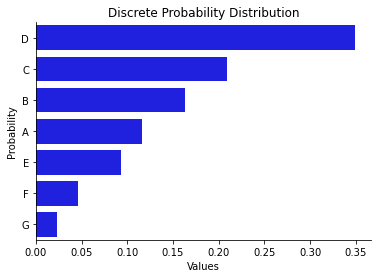

In [68]:
g_behind_data_set.draw_dpd()

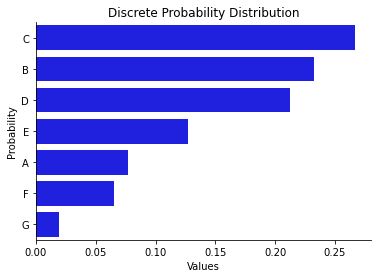

In [69]:
g_loss_data_set.draw_dpd()

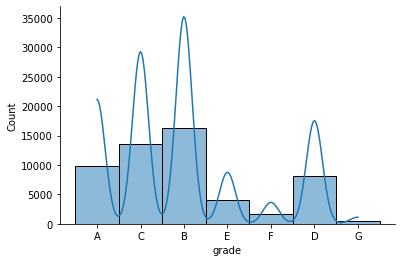

In [70]:
g_full_data_set.draw_density_plot()

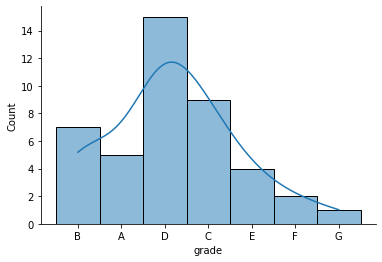

In [71]:
g_behind_data_set.draw_density_plot()

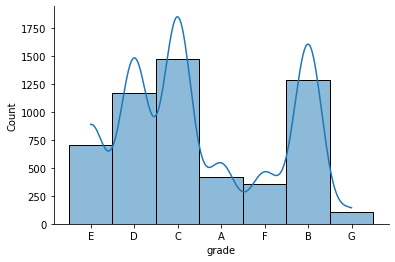

In [72]:
g_loss_data_set.draw_density_plot()

Visually Grade D seems more prevelant in the behind payments and charged off subsets.

Will compare the two susbsets with the entire sample quantatively using the proportion z test from the StatsTests class

In [73]:
grade_d_proportion_behind = StatsTests(payments_df_2, behind_loans, 'grade', 'D')
grade_d_proportion_behind.proportion_z_test()

sample size: 43
 proportion in sample: 0.3488372093023256
 proportion in population: 0.1503019334822995
 z score: 3.6429844095382693


In [74]:
grade_d_proportion_loss = StatsTests(payments_df_2, loss_loans, 'grade', 'D')
grade_d_proportion_loss.proportion_z_test()

sample size: 5503
 proportion in sample: 0.21242958386334726
 proportion in population: 0.1503019334822995
 z score: 12.896447275433466


The high Z score indicates grade D is at higher proportions in the behind payments and charged off samples at a statistically significant (P < 0.05) level.

In [75]:
# will now see if the purpose of the loan is an indicator of loss

p_full_data_set = Plotter(payments_df_2, 'purpose')
p_behind_data_set = Plotter(behind_loans, 'purpose')
p_loss_data_set = Plotter(loss_loans, 'purpose')

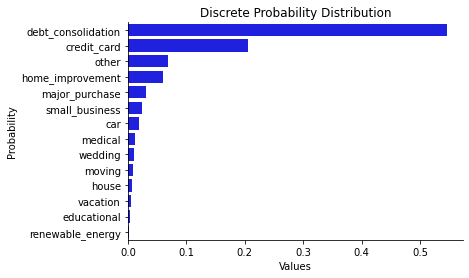

In [76]:
p_full_data_set.draw_dpd()

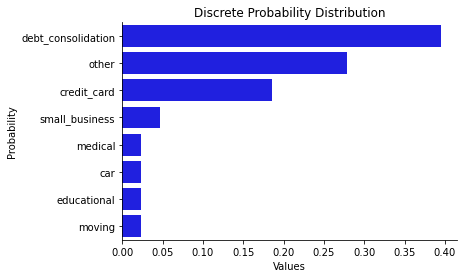

In [77]:
p_behind_data_set.draw_dpd()

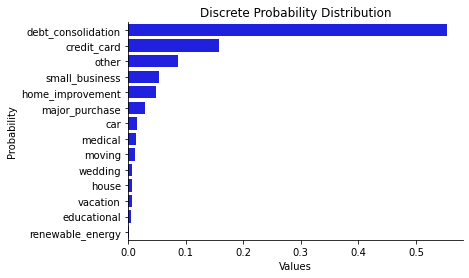

In [78]:
p_loss_data_set.draw_dpd()

"other" and small business appear to be more prevelant in the behind payments and charged off subsets and again this will be compared to the entire sample quantatively

In [79]:
other_proportion_behind = StatsTests(payments_df_2, behind_loans, 'purpose', 'other')
other_proportion_behind.proportion_z_test()

sample size: 43
 proportion in sample: 0.27906976744186046
 proportion in population: 0.06808738527451016
 z score: 5.492366326379207


In [80]:
other_proportion_loss = StatsTests(payments_df_2, loss_loans, 'purpose', 'other')
other_proportion_loss.proportion_z_test()

sample size: 5503
 proportion in sample: 0.08631655460657824
 proportion in population: 0.06808738527451016
 z score: 5.368410437001622


In [81]:
small_business_proportion_behind = StatsTests(payments_df_2, behind_loans, 'purpose', 'small_business')
small_business_proportion_behind.proportion_z_test()

sample size: 43
 proportion in sample: 0.046511627906976744
 proportion in population: 0.02409927794500563
 z score: 0.9583337608817023


In [82]:
small_business_proportion_loss = StatsTests(payments_df_2, loss_loans, 'purpose', 'small_business')
small_business_proportion_loss.proportion_z_test()

sample size: 5503
 proportion in sample: 0.05378884244957296
 proportion in population: 0.02409927794500563
 z score: 14.361465151539


"Other" is present at statistically significantly higher proportions in both the behind payments and charged off subsets.

small business is only present at statistically significantly higher proportions in the charged off subset

In [83]:
# will now see if home ownership is an indicator of loss

h_full_data_set = Plotter(payments_df_2, 'home_ownership')
h_behind_data_set = Plotter(behind_loans, 'home_ownership')
h_loss_data_set = Plotter(loss_loans, 'home_ownership')

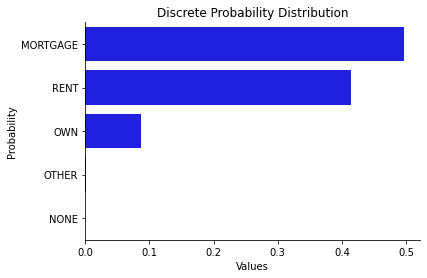

In [84]:
h_full_data_set.draw_dpd()

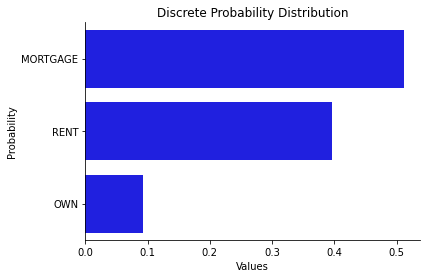

In [85]:
h_behind_data_set.draw_dpd()

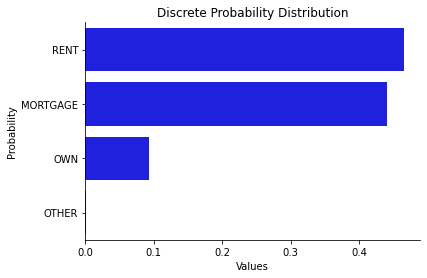

In [86]:
h_loss_data_set.draw_dpd()

Renters appear to be more prevelant in the charged off subset 

will compare z values for rent, mortage and own since there is only a small number of unique values to compare.

In [87]:
rent_proportion_behind = StatsTests(payments_df_2, behind_loans, 'home_ownership', 'RENT')
rent_proportion_behind.proportion_z_test()
rent_proportion_loss = StatsTests(payments_df_2, loss_loans, 'home_ownership', 'RENT')
rent_proportion_loss.proportion_z_test()

sample size: 43
 proportion in sample: 0.3953488372093023
 proportion in population: 0.41441524625584014
 z score: -0.25379928311726707
sample size: 5503
 proportion in sample: 0.4653825186262039
 proportion in population: 0.41441524625584014
 z score: 7.675000378628421


In [88]:
mortgage_proportion_behind = StatsTests(payments_df_2, behind_loans, 'home_ownership', 'MORTGAGE')
mortgage_proportion_behind.proportion_z_test()
mortgage_proportion_loss = StatsTests(payments_df_2, loss_loans, 'home_ownership', 'MORTGAGE')
mortgage_proportion_loss.proportion_z_test()

sample size: 43
 proportion in sample: 0.5116279069767442
 proportion in population: 0.49681446326014295
 z score: 0.19428043602718045
sample size: 5503
 proportion in sample: 0.4404870070870434
 proportion in population: 0.49681446326014295
 z score: -8.357159764913177


In [89]:
own_proportion_behind = StatsTests(payments_df_2, behind_loans, 'home_ownership', 'OWN')
own_proportion_behind.proportion_z_test()
own_proportion_loss = StatsTests(payments_df_2, loss_loans, 'home_ownership', 'OWN')
own_proportion_loss.proportion_z_test()

sample size: 43
 proportion in sample: 0.09302325581395349
 proportion in population: 0.08756994330667947
 z score: 0.12650779554678462
sample size: 5503
 proportion in sample: 0.09249500272578594
 proportion in population: 0.08756994330667947
 z score: 1.2925099797540494


## summary of home ownership stats:
- renters are more prevelant in the charged off subset but there is not a statistically significant difference for proportion of renters between the behind payments subset and the enitire sample
- there is not a statistically significant difference for proportion of people with mortgages between the behind payments subset and the enitire sample but they are statistically significantly less prevelant in the charged off subset compared to the entire sample
- no statistically significant difference in proportion of owners between the two subsets and the entire sample 


In [90]:
# will now see if employment length is an indicator of loss

e_full_data_set = Plotter(payments_df_2, 'employment_length')
e_behind_data_set = Plotter(behind_loans, 'employment_length')
e_loss_data_set = Plotter(loss_loans, 'employment_length')

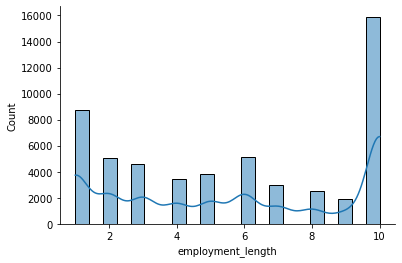

In [91]:
e_full_data_set.draw_density_plot()

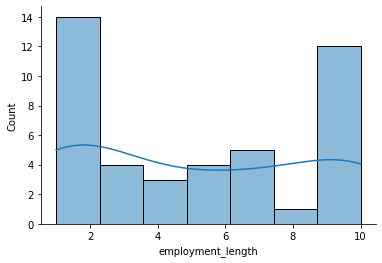

In [92]:
e_behind_data_set.draw_density_plot()

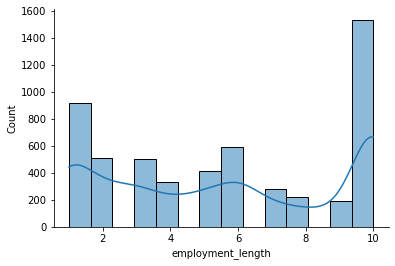

In [93]:
e_loss_data_set.draw_density_plot()

Cannot draw any conclusions for employment length as during cleaning < 1 year and > 10 years were changed to 1 and 10 respectively and 6 years is over represented in the sample due to the imputation method.

But visually it does look like people employed for 1 year or less are more likely to be behind on their loan payments.

In [94]:
# will now see if verification status is an indicator of loss 
v_full_data_set = Plotter(payments_df_2, 'verification_status')
v_behind_data_set = Plotter(behind_loans, 'verification_status')
v_loss_data_set = Plotter(loss_loans, 'verification_status')


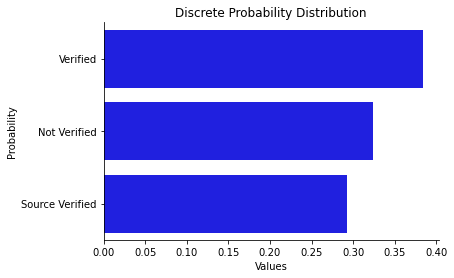

In [95]:
v_full_data_set.draw_dpd()

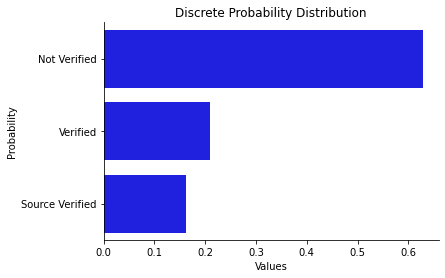

In [96]:
v_behind_data_set.draw_dpd()

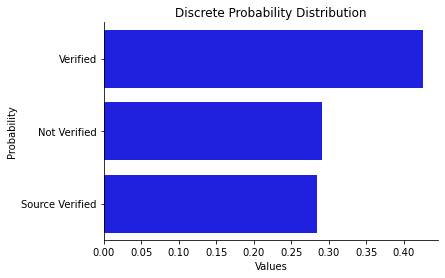

In [97]:
v_loss_data_set.draw_dpd()

not verified appears to be at much higher proportion for the behind payments population compared to the entire sample,
but will still find z values to compare once again.

In [98]:
verified_proportion_behind = StatsTests(payments_df_2, behind_loans, 'verification_status', 'Verified')
verified_proportion_behind.proportion_z_test()
verified_proportion_loss = StatsTests(payments_df_2, loss_loans, 'verification_status', 'Verified')
verified_proportion_loss.proportion_z_test()

sample size: 43
 proportion in sample: 0.20930232558139536
 proportion in population: 0.38335395468227734
 z score: -2.347439300248419
sample size: 5503
 proportion in sample: 0.4248591677266945
 proportion in population: 0.38335395468227734
 z score: 6.33263496644943


In [99]:
not_verified_proportion_behind = StatsTests(payments_df_2, behind_loans, 'verification_status', 'Not Verified')
not_verified_proportion_behind.proportion_z_test()
not_verified_proportion_loss = StatsTests(payments_df_2, loss_loans, 'verification_status', 'Not Verified')
not_verified_proportion_loss.proportion_z_test()

sample size: 43
 proportion in sample: 0.627906976744186
 proportion in population: 0.3236874665287806
 z score: 4.263680280623516
sample size: 5503
 proportion in sample: 0.2907504997274214
 proportion in population: 0.3236874665287806
 z score: -5.222118213992703


In [100]:
source_verified_proportion_behind = StatsTests(payments_df_2, behind_loans, 'verification_status', 'Source Verified')
source_verified_proportion_behind.proportion_z_test()
source_verified_proportion_loss = StatsTests(payments_df_2, loss_loans, 'verification_status', 'Source Verified')
source_verified_proportion_loss.proportion_z_test()

sample size: 43
 proportion in sample: 0.16279069767441862
 proportion in population: 0.29295857878894205
 z score: -1.875480377188533
sample size: 5503
 proportion in sample: 0.2843903325458841
 proportion in population: 0.29295857878894205
 z score: -1.3965810889083783


## Summary of Verification Status Stats:
- source verfied loans were statistically significantly different between the two subsets and entire sample.
- verified loans were higher in proportion for the charged off subset compared to the entire sample but lower in proportion for the behind payments subset. 
- non verified loans were higher in proportion for the behind payments subset compared to the entire sample but lower in proportion for the charged off subset.